In [1]:
!unzip '/content/drive/MyDrive/MPS Data Science Final Year Project/gas+sensor+array+under+dynamic+gas+mixtures.zip'

Archive:  /content/drive/MyDrive/MPS Data Science Final Year Project/gas+sensor+array+under+dynamic+gas+mixtures.zip
  inflating: ethylene_CO.txt         
  inflating: ethylene_methane.txt    


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score


In [3]:
ethelene_co_df = pd.read_csv("/content/ethylene_CO.txt", delim_whitespace=True,skiprows=[0], header=None)
ethelene_methane_df = pd.read_csv("/content/ethylene_methane.txt", delim_whitespace=True,skiprows=[0], header=None)

In [4]:
ethelene_co_df = ethelene_co_df.rename(columns = {0:'Time', 1:'CO2 conc (ppm)', 2:'Ethylene conc (ppm)', 3:'Sensor1',4:'Sensor2',5:'Sensor3',6:'Sensor4',7:'Sensor5',8:'Sensor6',9:'Sensor7',10:'Sensor8',11:'Sensor9',12:'Sensor10',13:'Sensor11',14:'Sensor12',15:'Sensor13',16:'Sensor14',17:'Sensor15',18:'Sensor16'})
ethelene_methane_df = ethelene_methane_df.rename(columns = {0:'Time', 1:'CO2 conc (ppm)', 2:'Ethylene conc (ppm)', 3:'Sensor1',4:'Sensor2',5:'Sensor3',6:'Sensor4',7:'Sensor5',8:'Sensor6',9:'Sensor7',10:'Sensor8',11:'Sensor9',12:'Sensor10',13:'Sensor11',14:'Sensor12',15:'Sensor13',16:'Sensor14',17:'Sensor15',18:'Sensor16'})

In [5]:
ethelene_co_df.head()

Time  CO2 conc (ppm)  Ethylene conc (ppm)  Sensor1  Sensor2  Sensor3  \
0  0.00             0.0                  0.0   -50.85    -1.95   -41.82   
1  0.01             0.0                  0.0   -49.40    -5.53   -42.78   
2  0.01             0.0                  0.0   -40.04   -16.09   -27.59   
3  0.03             0.0                  0.0   -47.14   -10.57   -32.28   
4  0.04             0.0                  0.0   -33.58   -20.79   -33.25   

   Sensor4  Sensor5  Sensor6  Sensor7  Sensor8   Sensor9  Sensor10  Sensor11  \
0     1.30    -4.07   -28.73   -13.49    -3.25  55139.95  50669.50   9626.26   
1     0.49     3.58   -34.55    -9.59     5.37  54395.77  50046.91   9433.20   
2     0.00    -7.16   -42.14   -12.52    -5.86  53960.02  49299.30   9324.40   
3     4.40   -11.22   -37.94    -7.16    -1.14  53047.71  48907.00   9170.64   
4     6.03     3.42   -34.22   -14.46     8.31  52700.28  48330.96   9073.64   

   Sensor12  Sensor13  Sensor14  Sensor15  Sensor16  
0   9762.62  24544.02  21420.68   7650.61   6928.42  
1   9591.21  24137.13  20930.33   7498.79   6800.66  
2   9449.81  23628.90  20504.94   7369.67   6697.47  
3   9305.58  23101.66  20101.42   7285.13   6578.52  
4   9163.47  22689.54  19694.07   7156.74   6468.32

**Statistical Analysis to understand Anamolaies in Data.**

In [ ]:
sensor_columns = ethelene_co_df.columns[3:]

# Define a threshold for flagging anomalies (e.g., 2 standard deviations from the mean)
threshold = 3

# Create a DataFrame to store detected anomalies
anomalies = pd.DataFrame(sensor_columns)

# Loop through each sensor and detect anomalies
for sensor_column in sensor_columns:
    z_scores = (ethelene_co_df[sensor_column] - ethelene_co_df[sensor_column].mean()) / ethelene_co_df[sensor_column].std()
    sensor_anomalies = ethelene_co_df[sensor_column][abs(z_scores) > threshold]
    anomalies[sensor_column] = sensor_anomalies
print("Detected Anomalies using Z-Scores:")
print(anomalies)

Detected Anomalies using Z-Scores:
           0  Sensor1  Sensor2  Sensor3  Sensor4  Sensor5  Sensor6  Sensor7  \
0    Sensor1      NaN      NaN      NaN      NaN    -4.07   -28.73      NaN   
1    Sensor2      NaN      NaN      NaN      NaN     3.58   -34.55      NaN   
2    Sensor3      NaN      NaN      NaN      NaN    -7.16   -42.14      NaN   
3    Sensor4      NaN      NaN      NaN      NaN   -11.22   -37.94      NaN   
4    Sensor5      NaN      NaN      NaN      NaN     3.42   -34.22      NaN   
5    Sensor6      NaN      NaN      NaN      NaN     0.33   -29.05      NaN   
6    Sensor7      NaN      NaN      NaN      NaN    -7.97   -30.34      NaN   
7    Sensor8      NaN      NaN      NaN      NaN    -2.28   -24.35      NaN   
8    Sensor9      NaN      NaN      NaN      NaN    -2.12   -27.59      NaN   
9   Sensor10      NaN      NaN      NaN      NaN    -0.65   -35.52      NaN   
10  Sensor11      NaN      NaN      NaN      NaN     4.56   -27.92      NaN   
11  Sensor12     

**Z-score didn't work well on the time series anomaly.**

In [ ]:

def plot_sensor_scatter(df, sensor_name):

    if sensor_name not in df.columns:
        print(f"'{sensor_name}' not found in the DataFrame.")
        return

    # Extracting the 'Time (seconds)' and sensor data
    time_data = df['Time']
    sensor_data = df[sensor_name]

    # Creating a scatter plot
    plt.figure(figsize=(12, 6))  # figure size as needed
    plt.scatter(time_data, sensor_data, marker='o', s=20, c='blue', label=f'{sensor_name}')
    plt.title(f'Scatter Plot of Time vs. {sensor_name}')
    plt.xlabel('Time')
    plt.ylabel(f'{sensor_name} Value')
    plt.grid(True)
    plt.legend()

    # Showing the plot
    plt.tight_layout()
    plt.show()





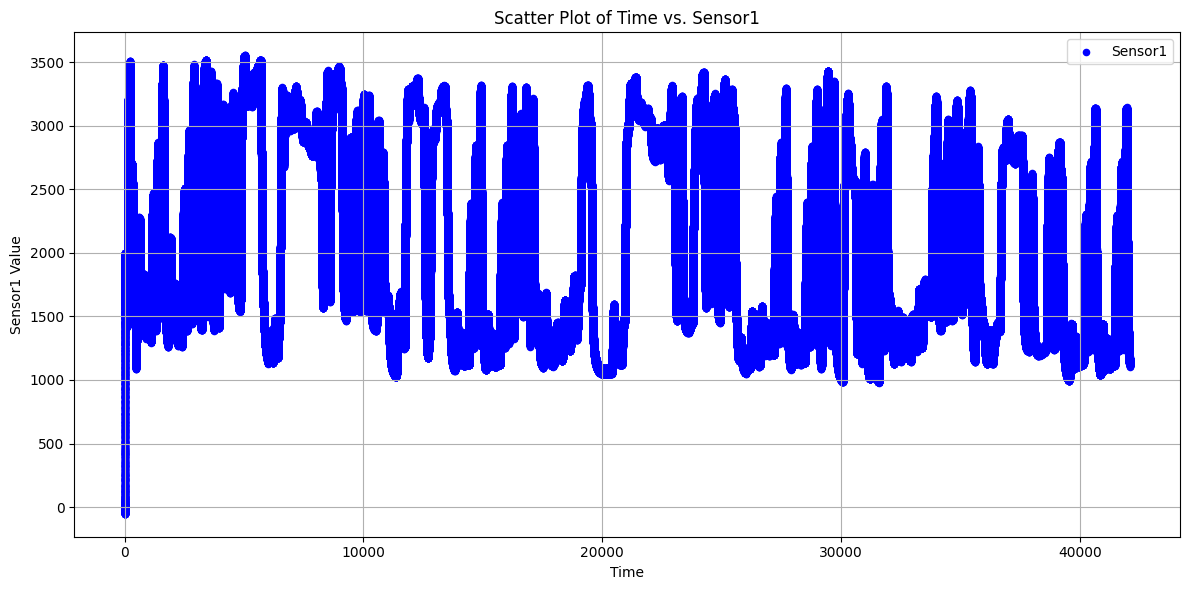

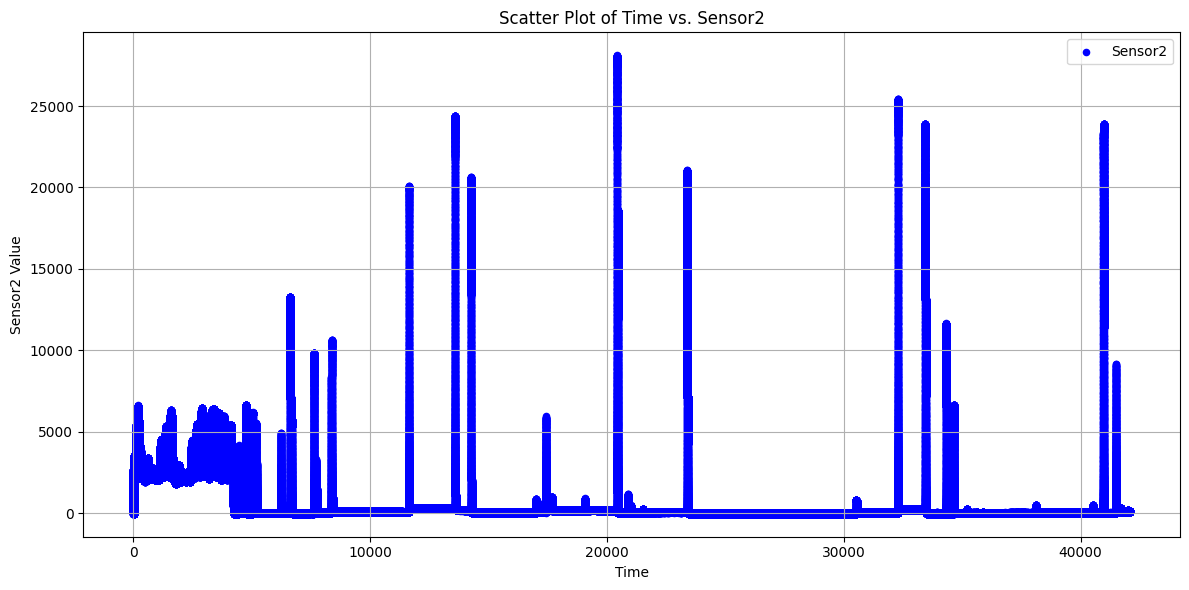

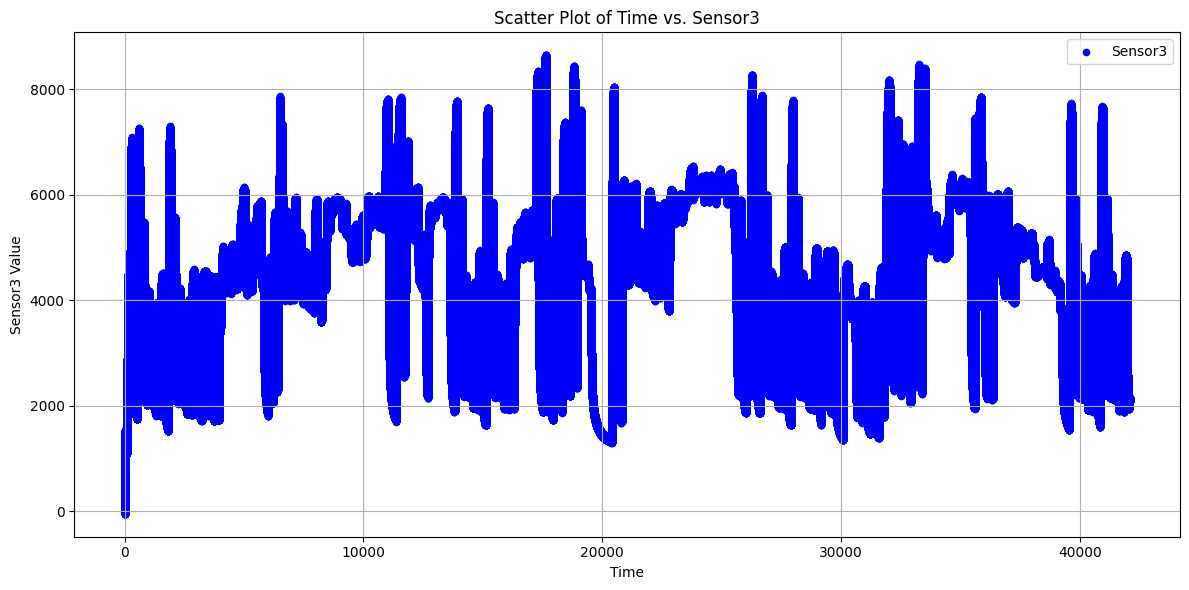

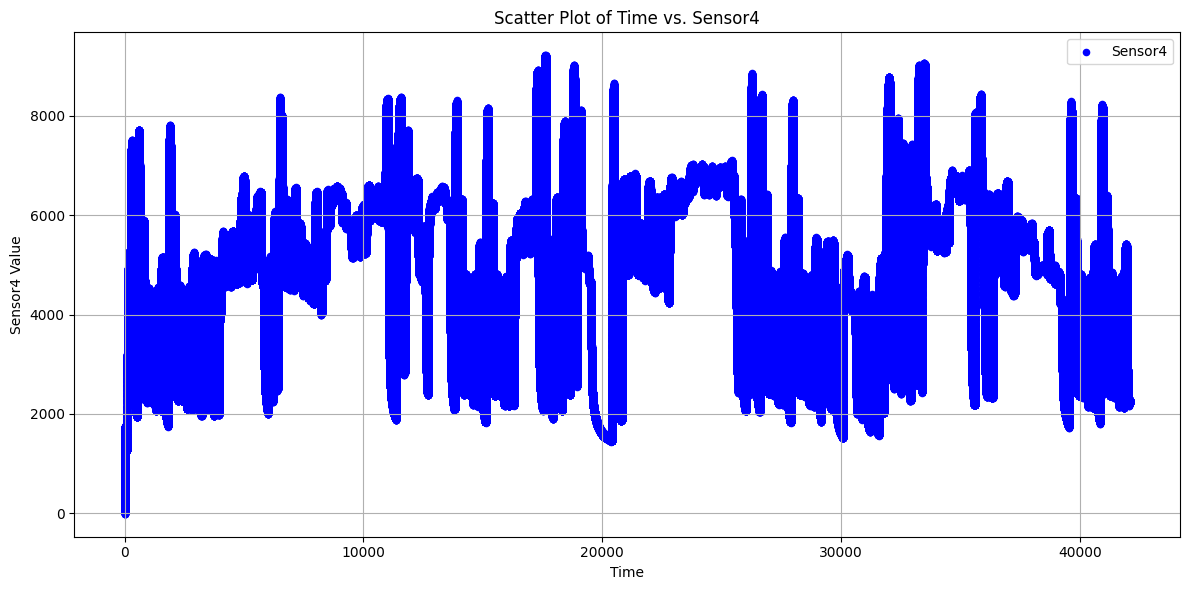

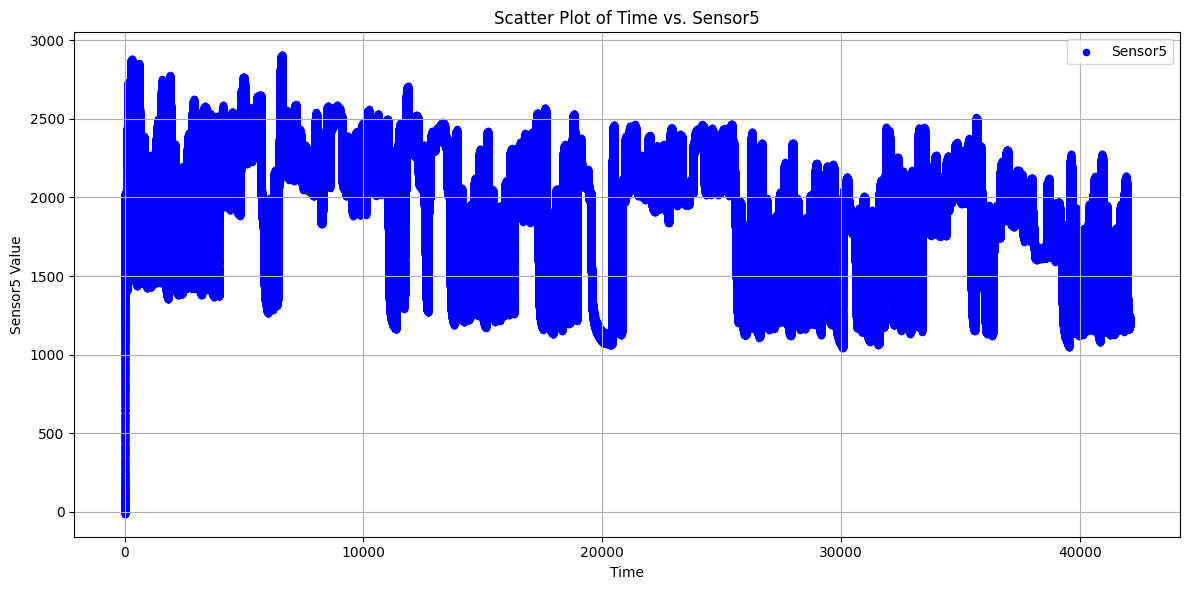

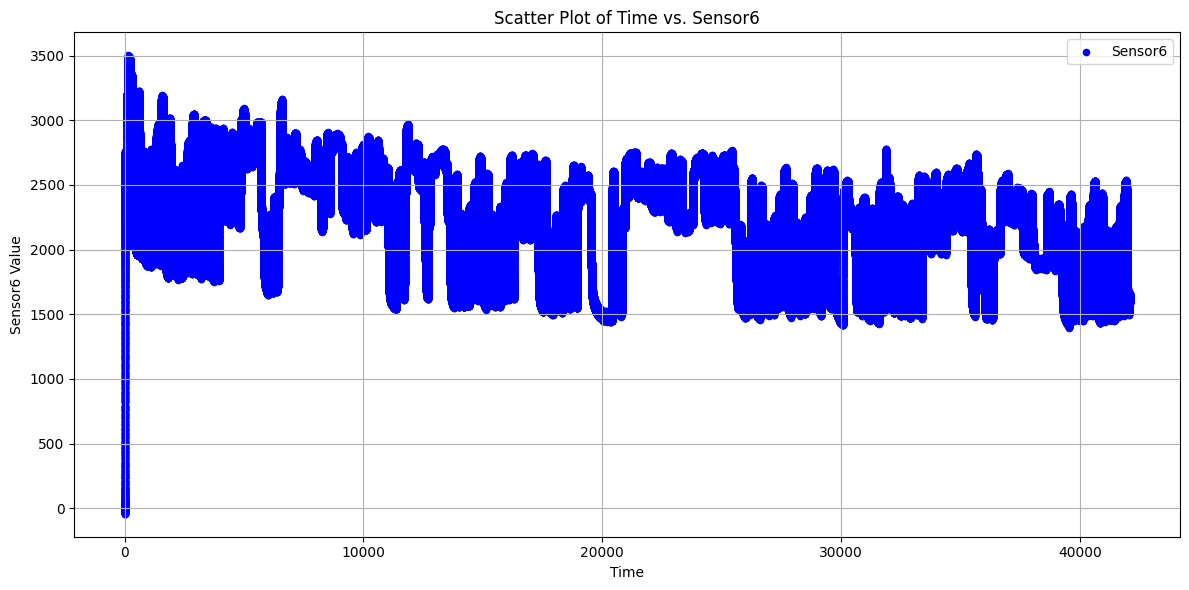

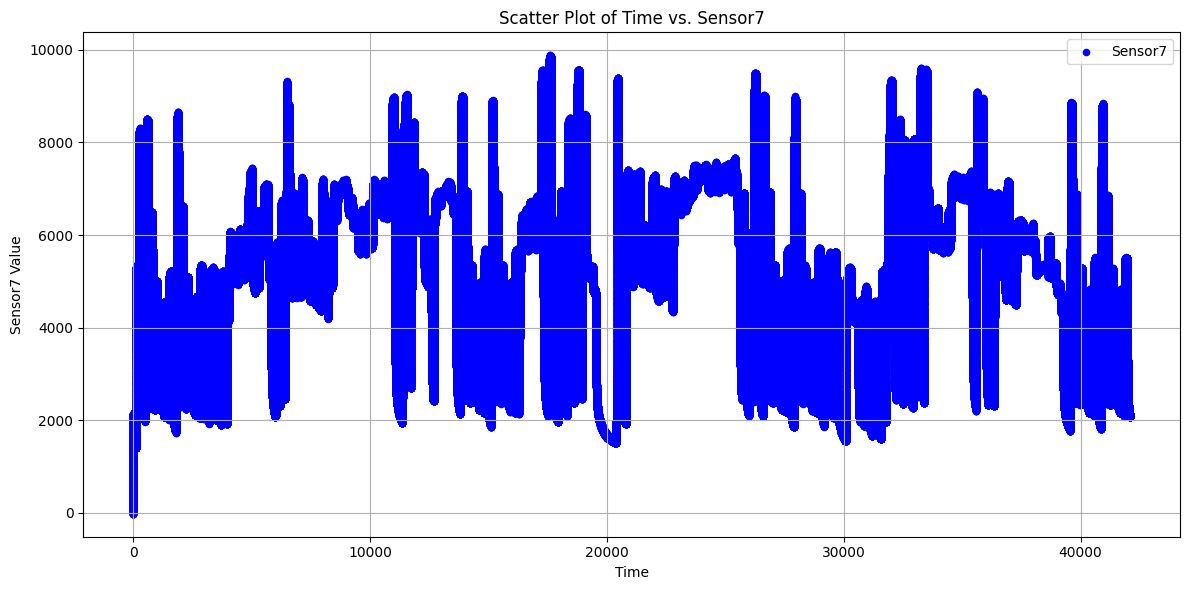

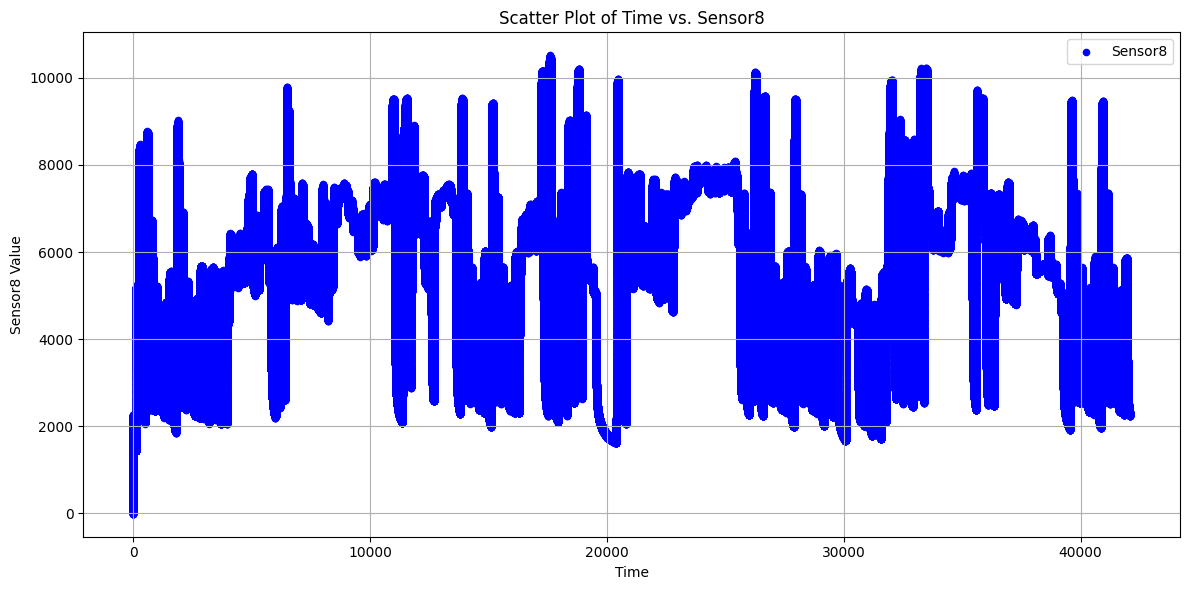

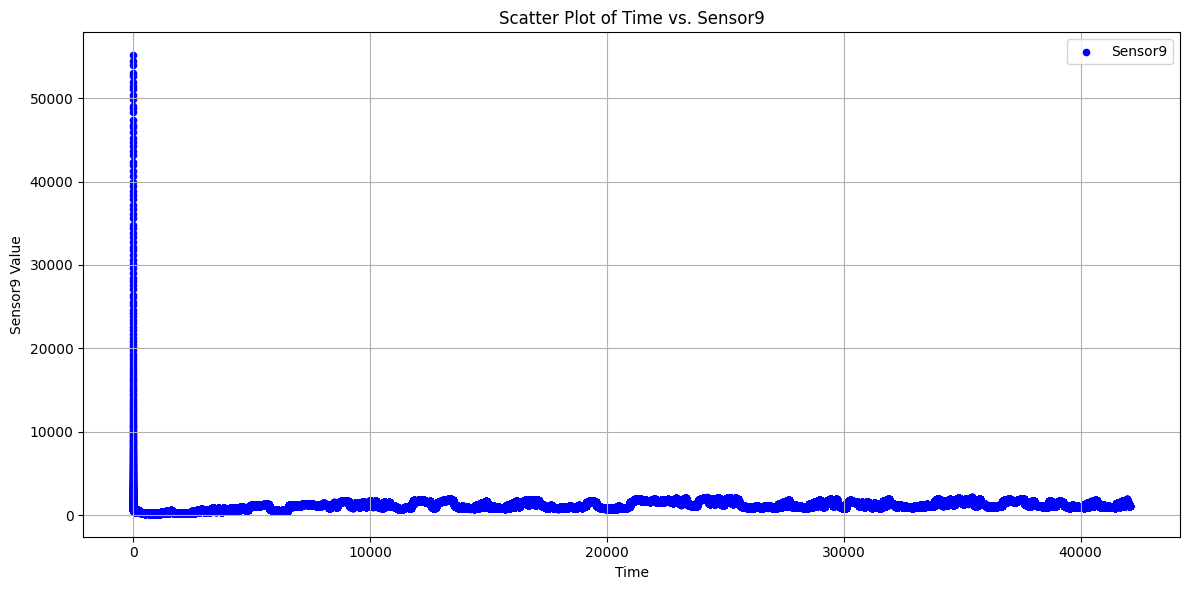

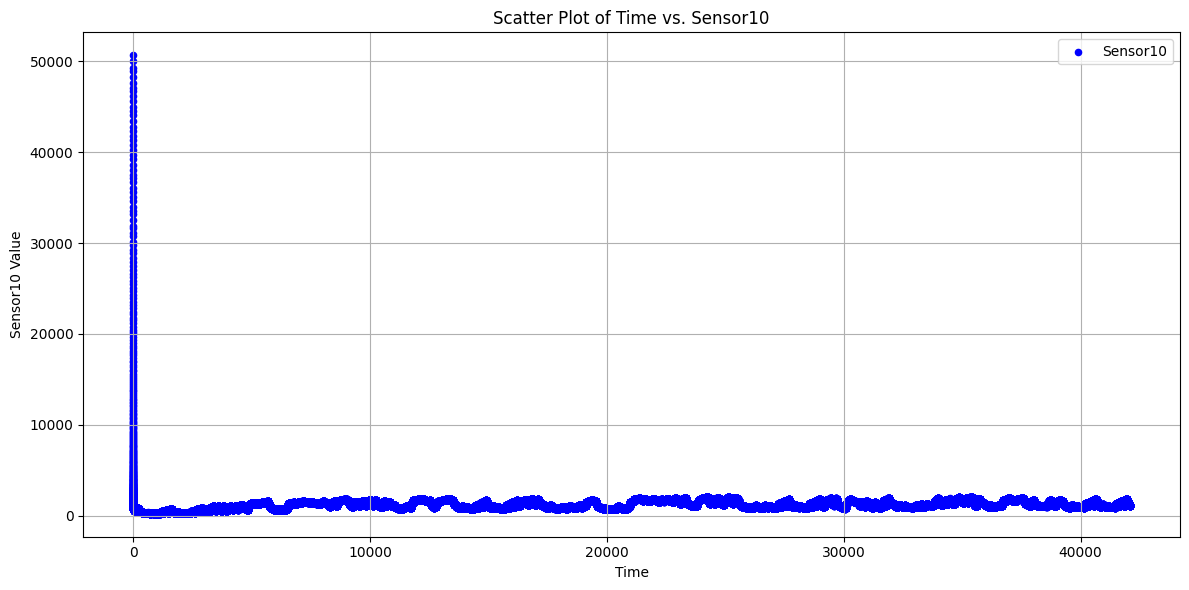

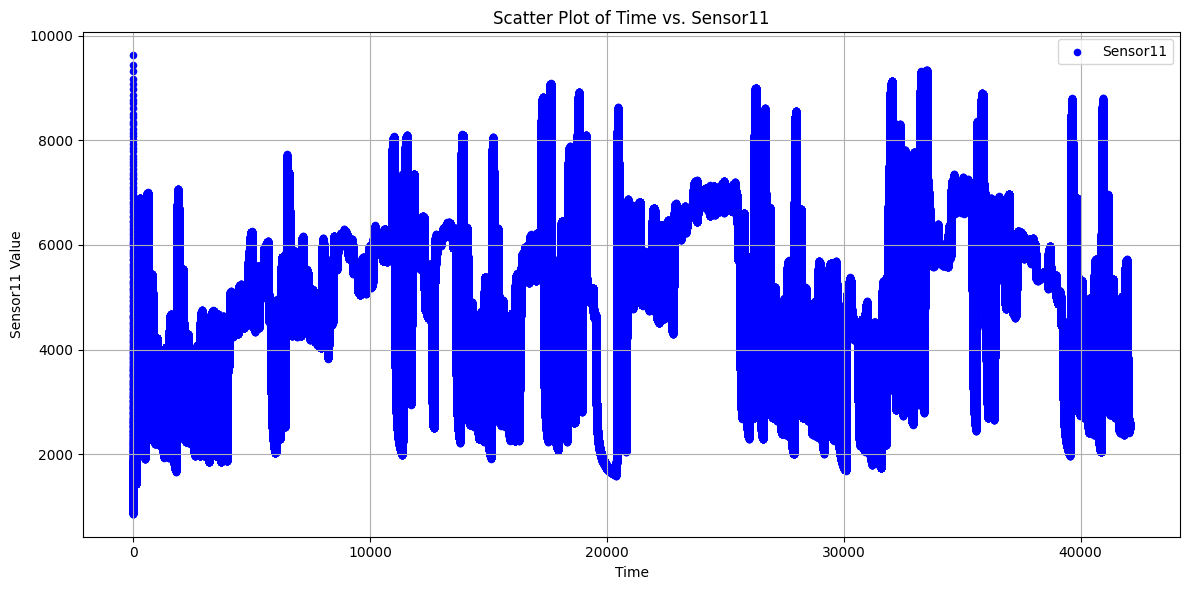

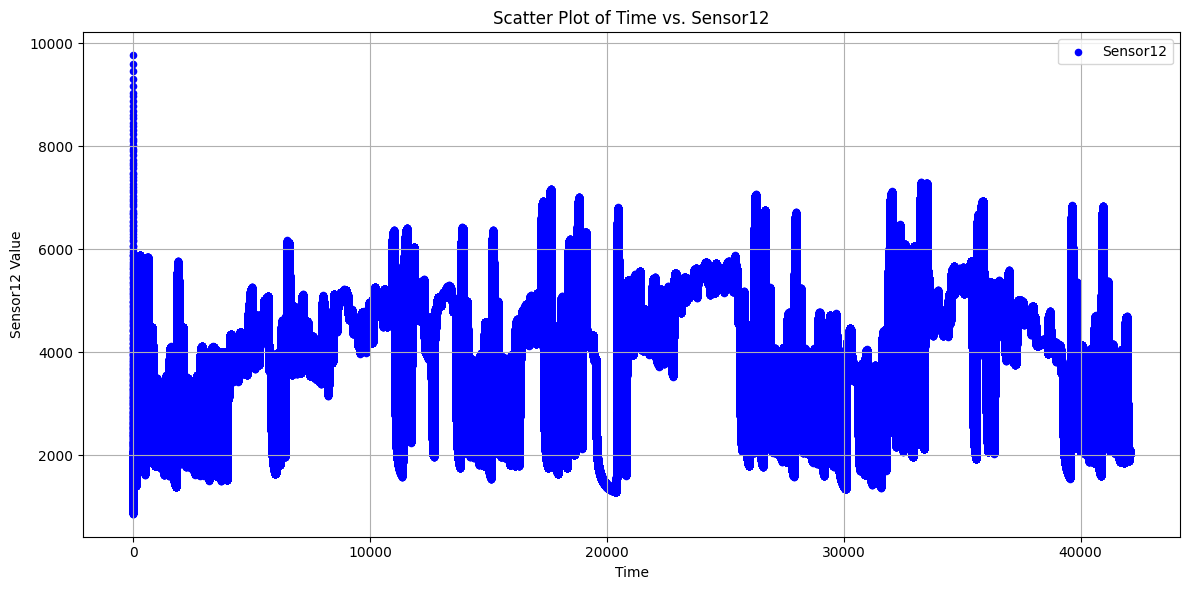

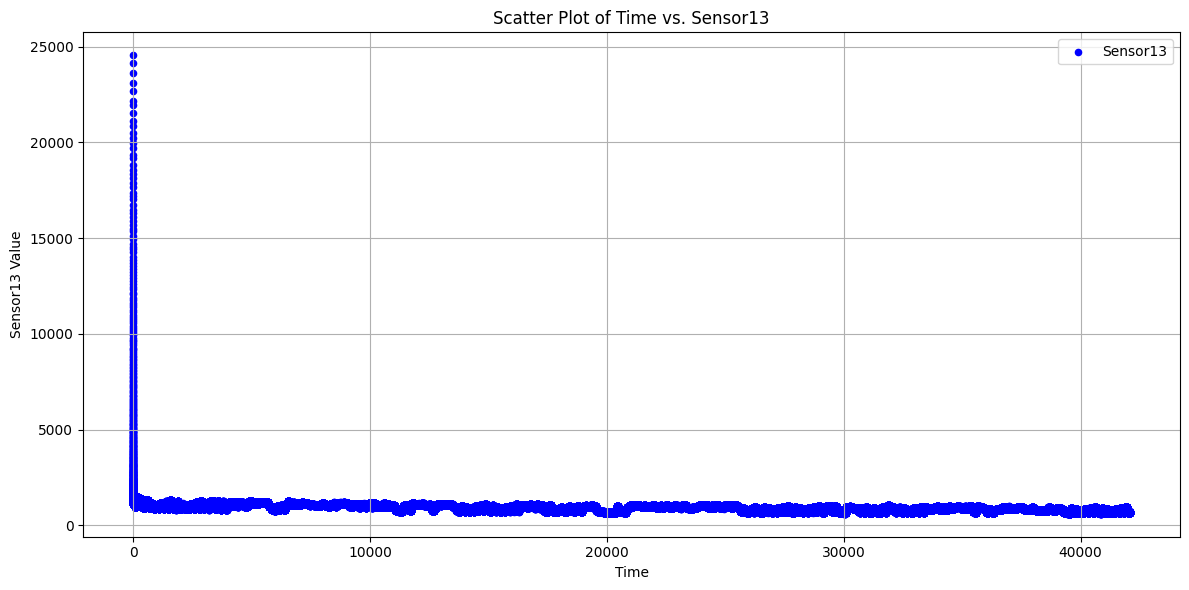

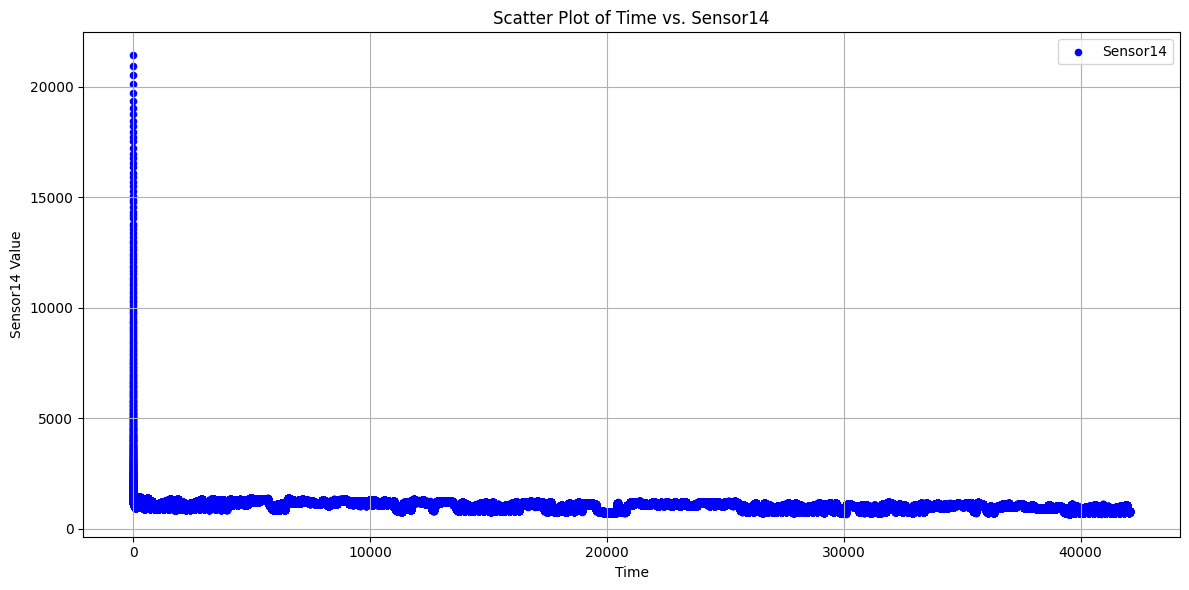

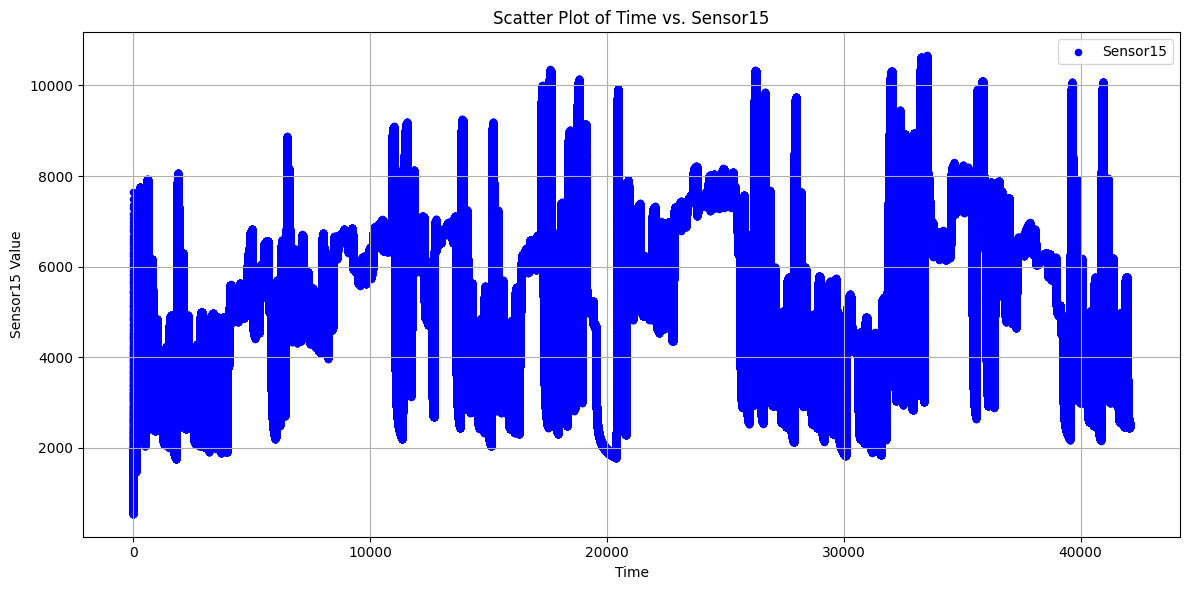

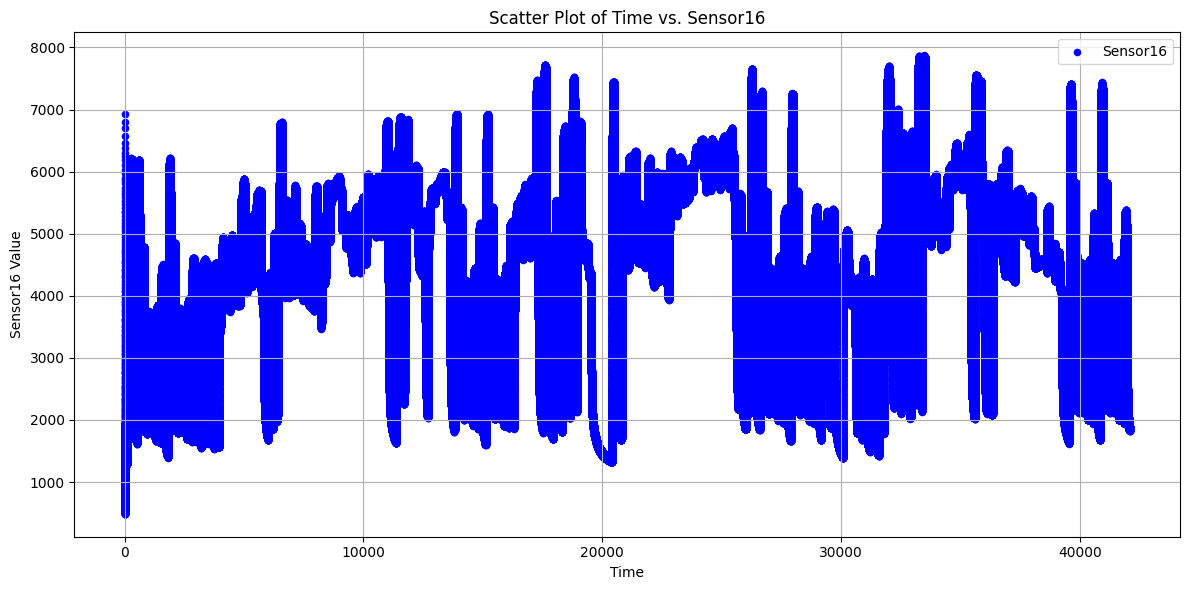

In [ ]:
# List of sensor names (replace with your actual sensor column names)
sensor_names = ['Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6',
                'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12',
                'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16']

# Loop through all sensors and create scatter plots
for sensor_name in sensor_names:
    plot_sensor_scatter(ethelene_co_df, sensor_name)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_and_visualize_anomalies(df, sensor_name, threshold=1.5, plot_interpolated=False):

    if sensor_name not in df.columns:
        print(f"'{sensor_name}' not found in the DataFrame.")
        return

    # Extract the sensor data
    sensor_data = df[sensor_name]

    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(sensor_data, 25)
    Q3 = np.percentile(sensor_data, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define upper and lower bounds for anomalies
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify anomalies
    anomalies = df[(sensor_data < lower_bound) | (sensor_data > upper_bound)]

    # Plot the sensor data
    plt.figure(figsize=(12, 6))
    plt.plot(df['Time'], sensor_data, label=f'{sensor_name} Data', marker='o', markersize=5)

    # Highlight anomalies
    if len(anomalies) > 0:
        plt.scatter(anomalies['Time'], anomalies[sensor_name], color='red', label='Anomalies', marker='x', s=50)

    # Interpolate and plot
    if plot_interpolated:
        interpolated_data = df.interpolate()
        plt.plot(interpolated_data['Time'], interpolated_data[sensor_name], linestyle='--', color='gray', label='Interpolated')

    # Customize the plot
    plt.title(f'Sensor Data and Anomalies for {sensor_name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel(f'{sensor_name} Value')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()




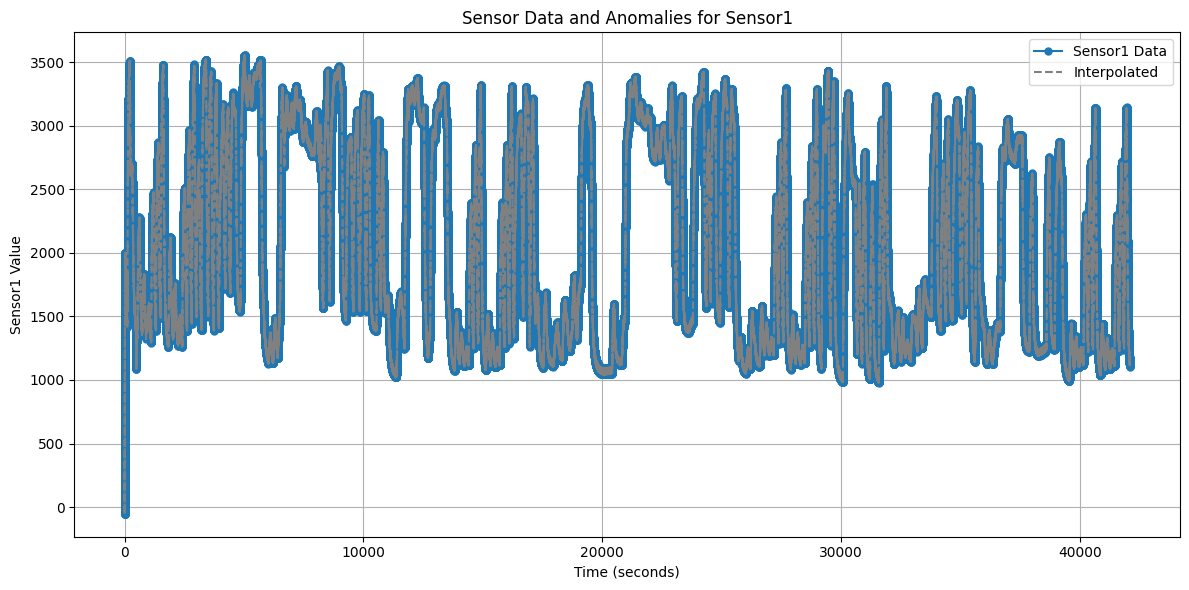

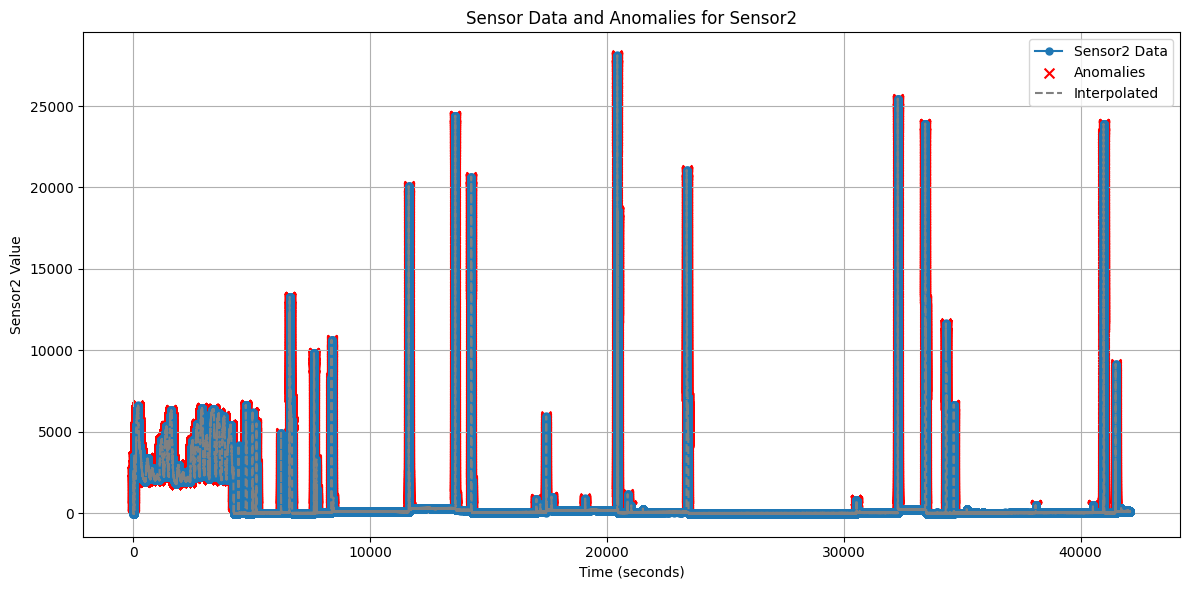

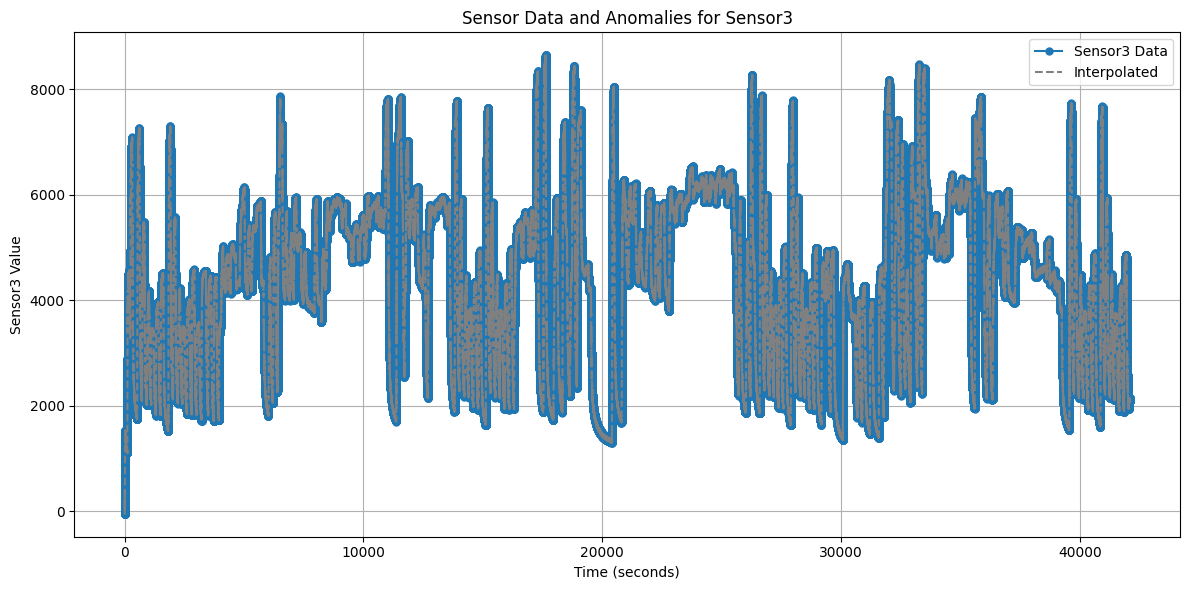

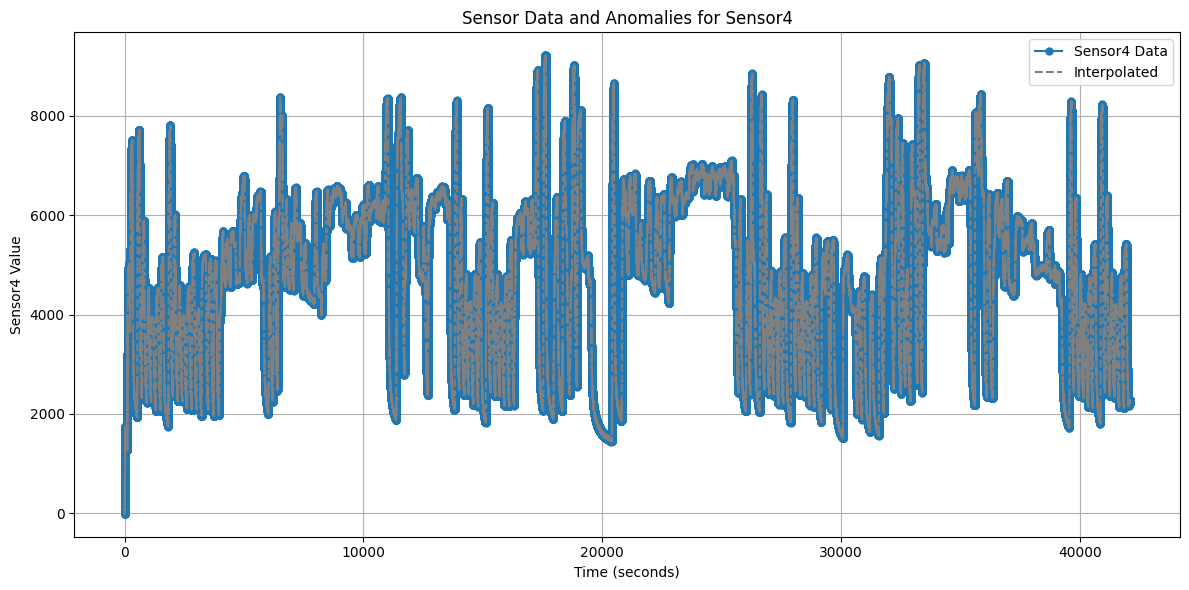

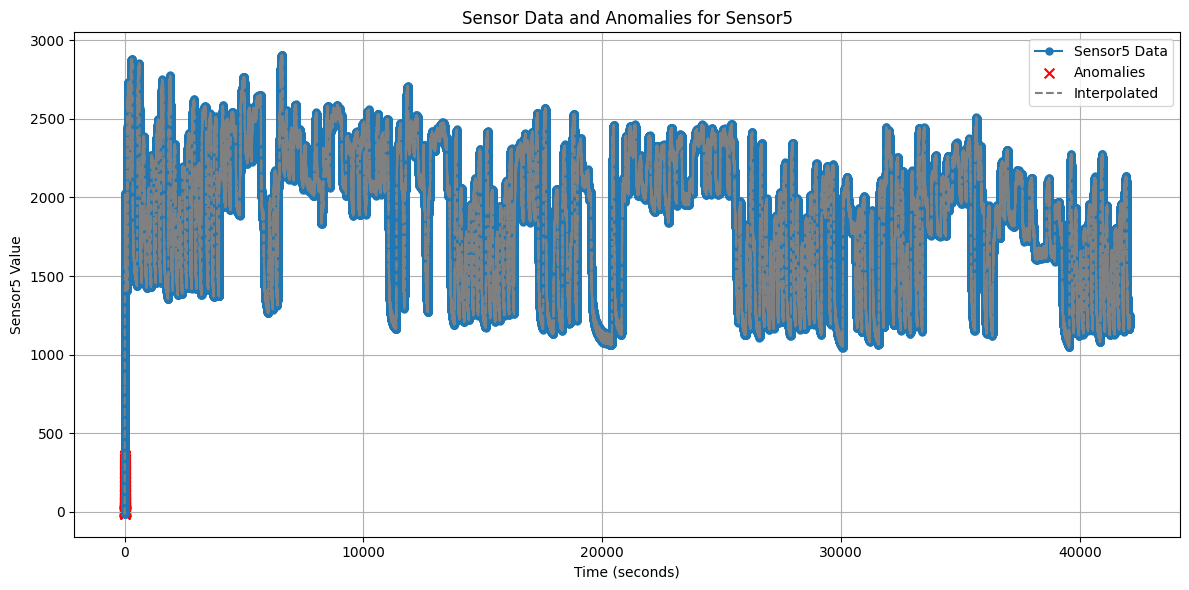

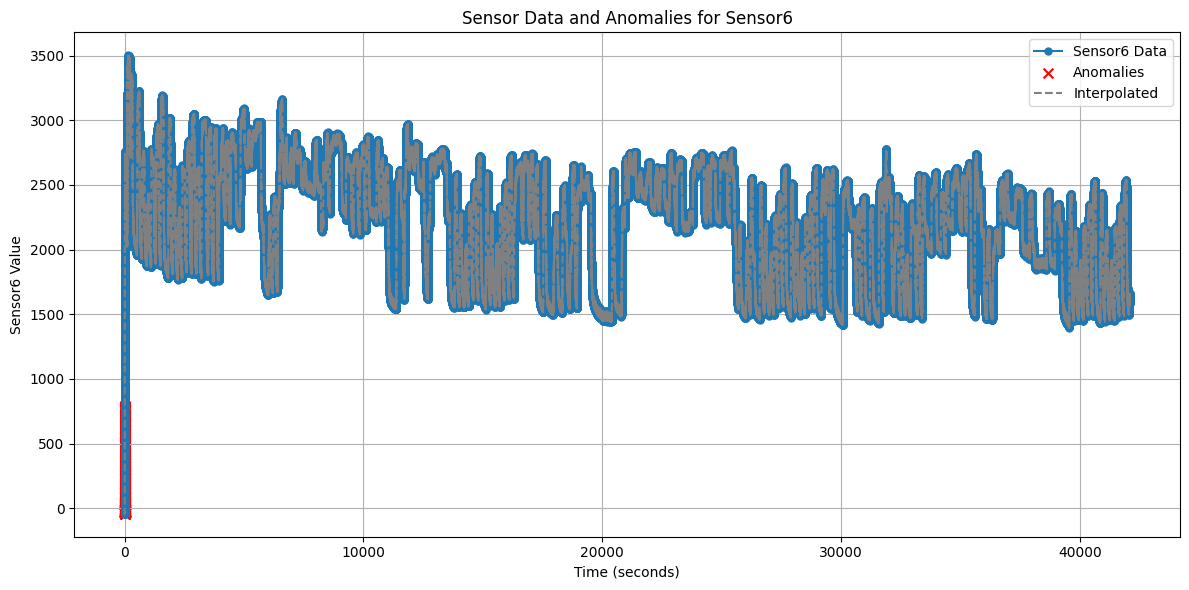

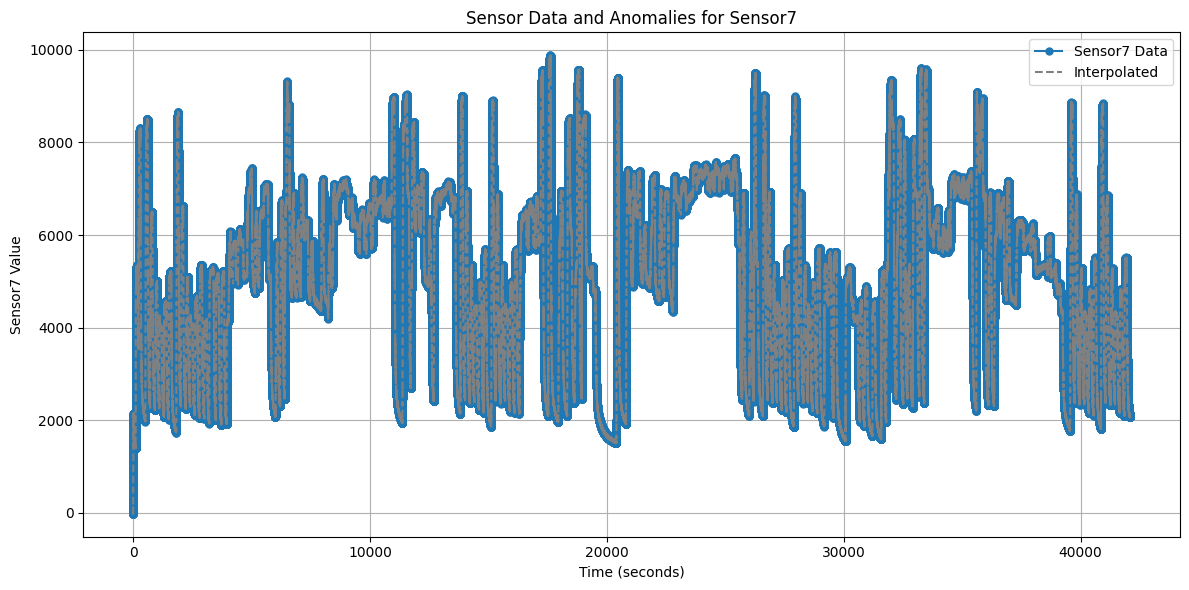

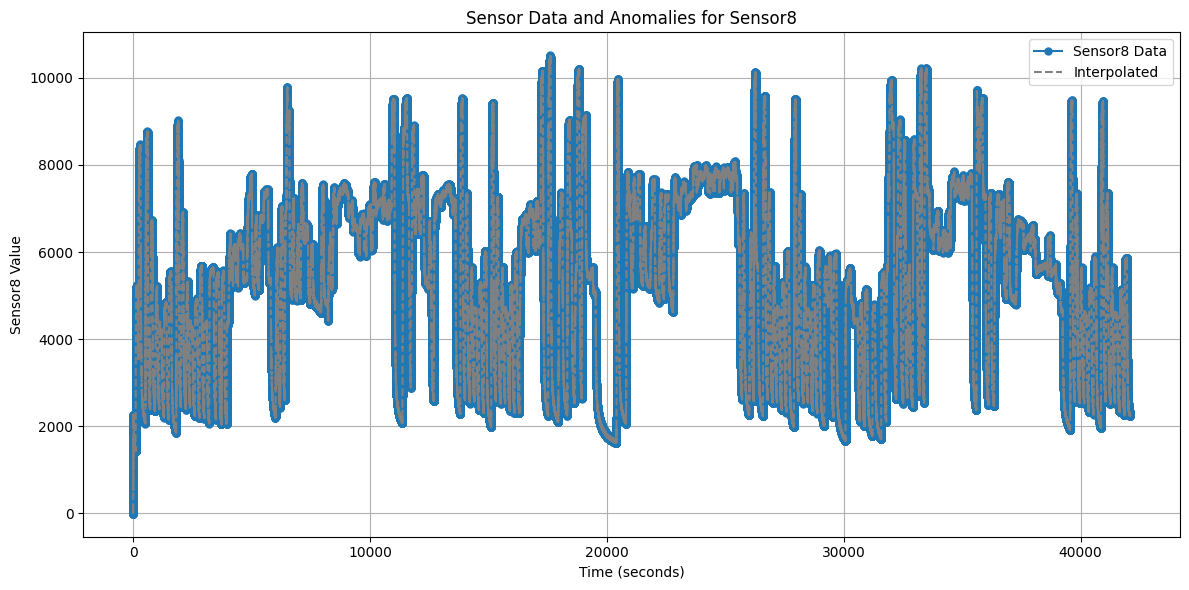

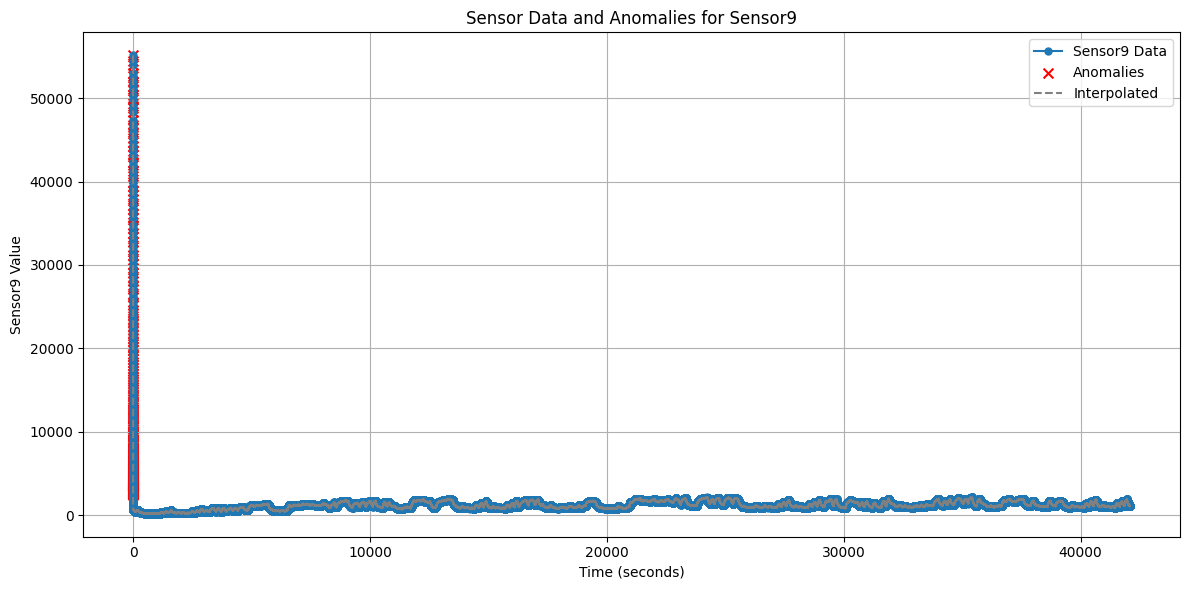

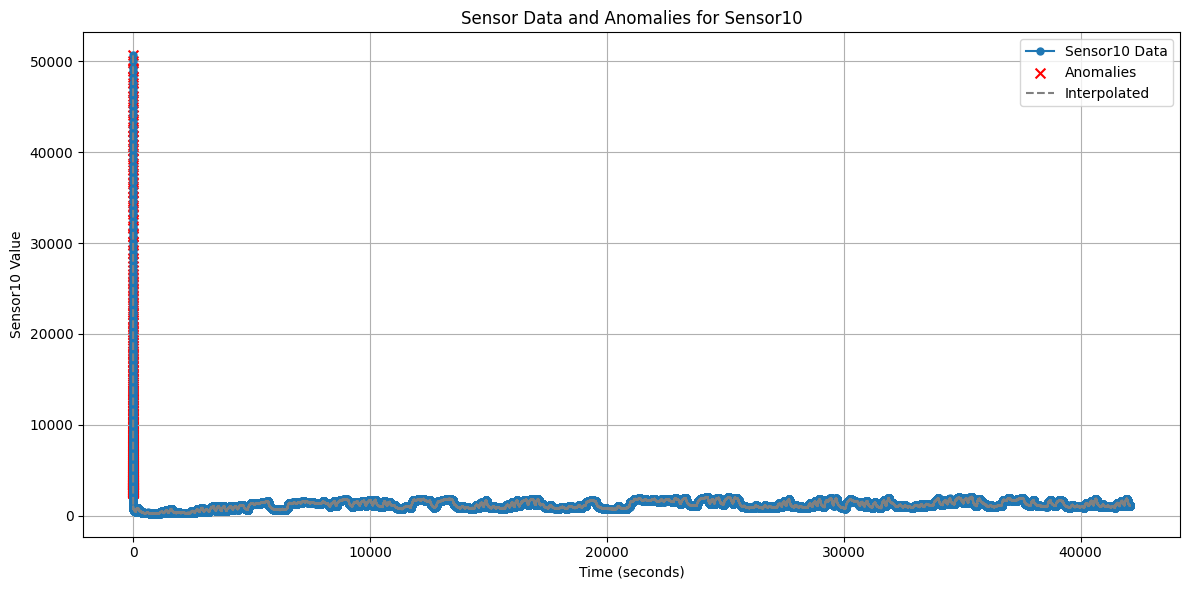

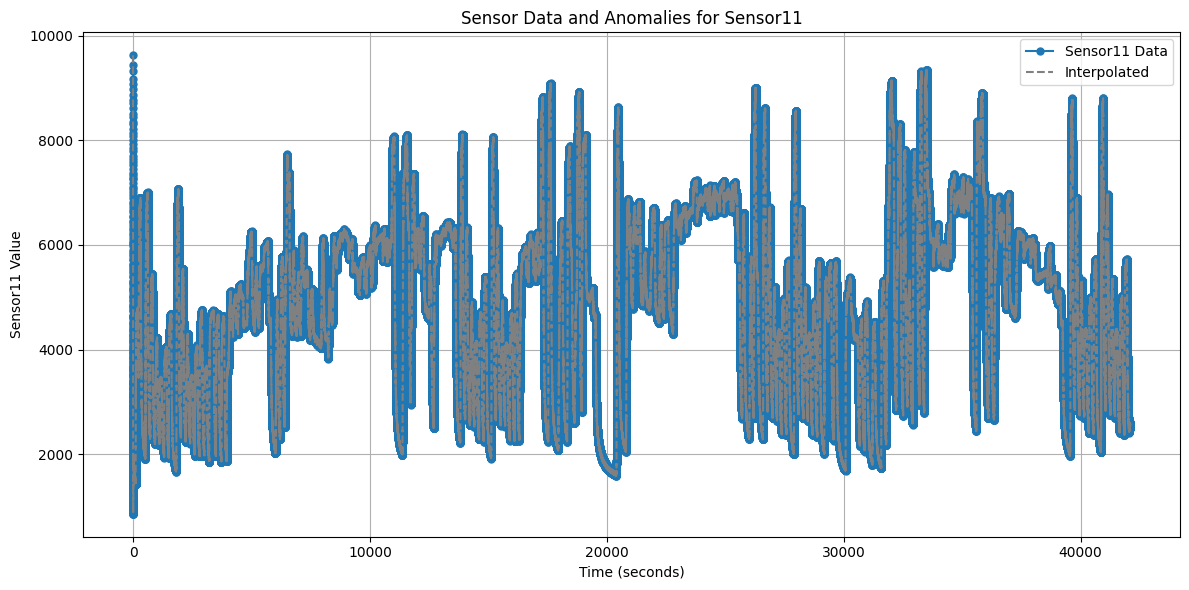

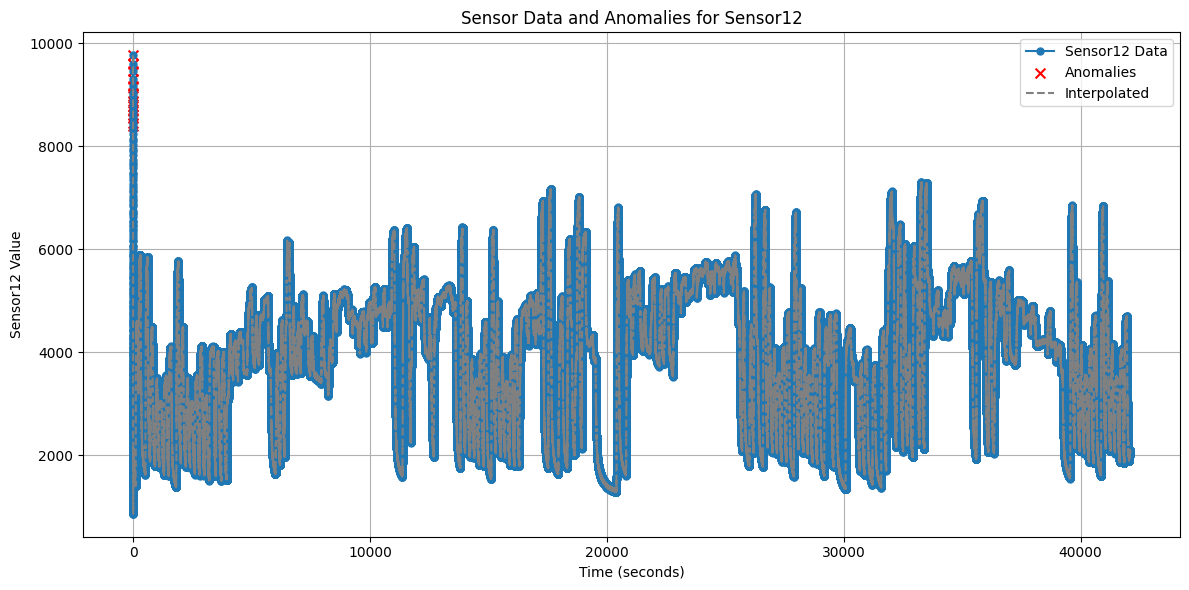

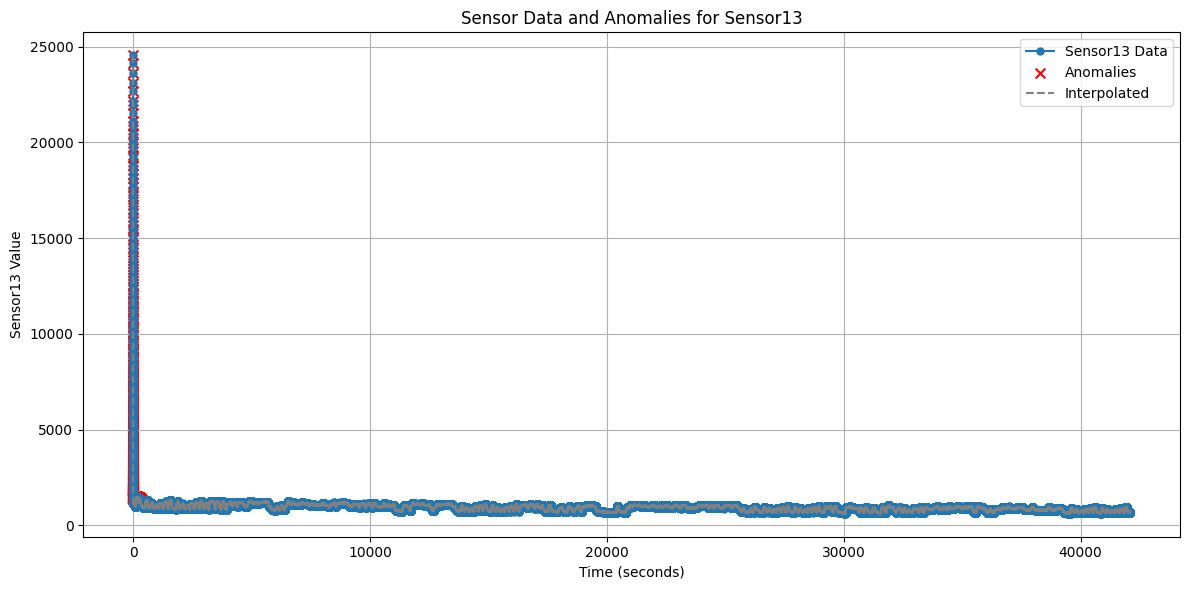

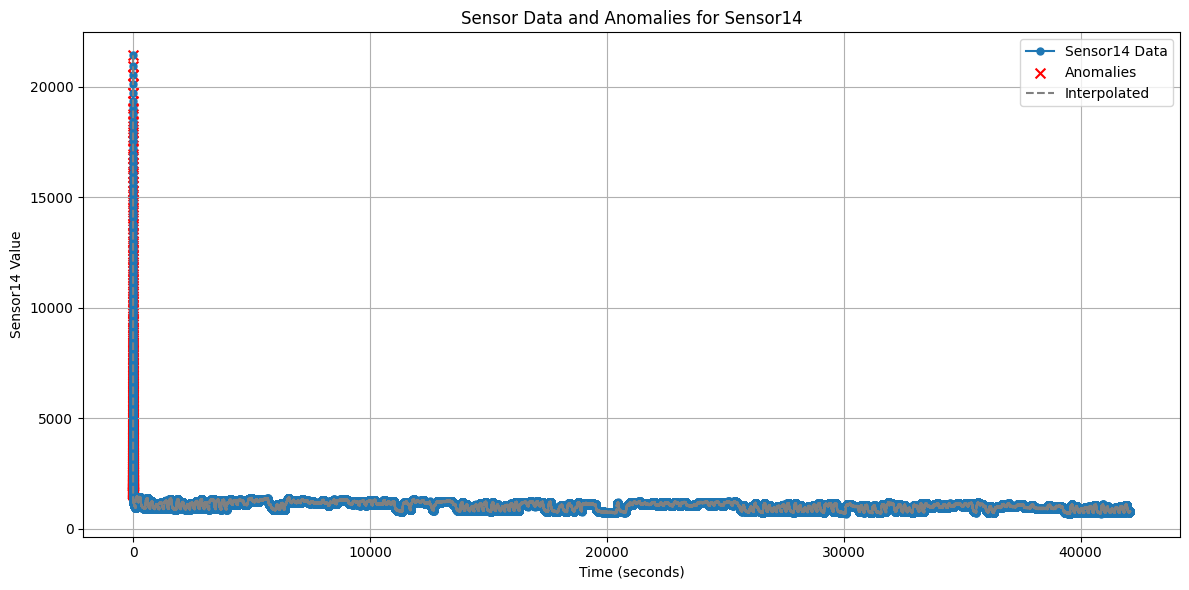

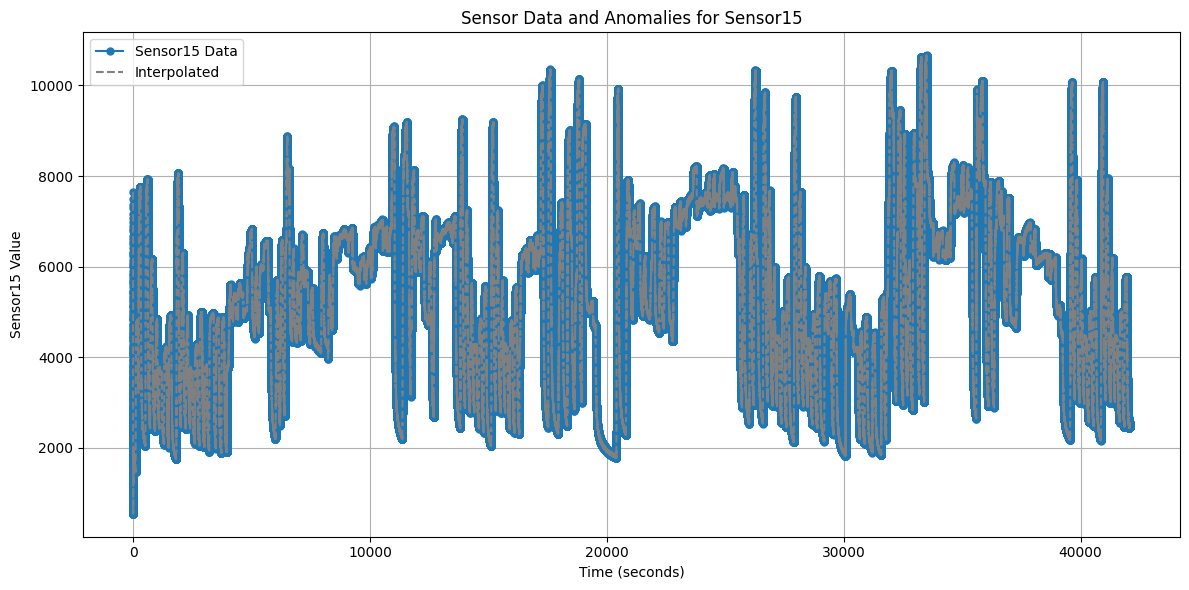

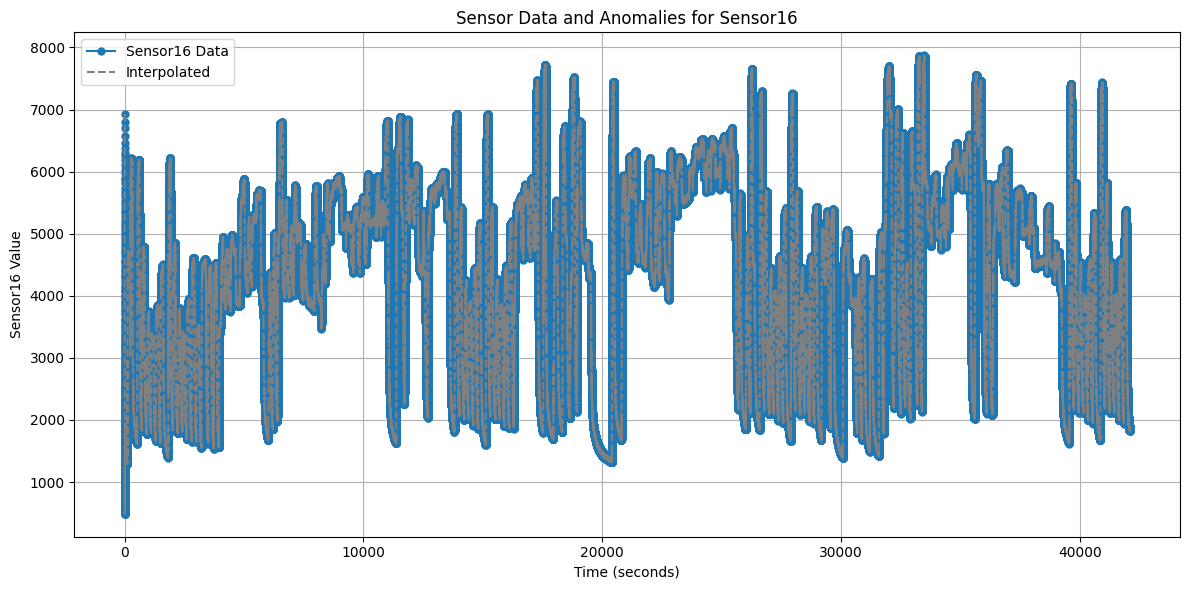

In [ ]:
# List of sensor names (replace with your actual sensor column names)
sensor_names = ['Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6',
                'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12',
                'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16']

# Loop through all sensors and create anomaly plots
for sensor_name in sensor_names:
    detect_and_visualize_anomalies(ethelene_co_df, sensor_name, threshold=1.5, plot_interpolated=True)


**Machine Learning Model**

**Model Training**

**Isolation Forest(Baseline Model)**

In [6]:
features = ethelene_co_df.iloc[:, 1:]
# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test = train_test_split(features_scaled, test_size=0.2, random_state=42)

# Train Isolation Forest model on the training set
isolation_forest = IsolationForest(contamination=0.05)
isolation_forest.fit(X_train)

# Predict anomalies on the testing set
predictions = isolation_forest.predict(X_test)


In [7]:
# Calculate average outliers in the training data
average_outliers_train = np.mean(isolation_forest.score_samples(X_train))

# Calculate average outliers in the test data
average_outliers_test = np.mean(isolation_forest.score_samples(X_test))

# Print rounded values
print('Average Outliers in the Training data:', round(average_outliers_train, 2))
print('Average Outliers in the Test data:', round(average_outliers_test, 2))


Average Outliers in the Training data: -0.47
Average Outliers in the Test data: -0.47


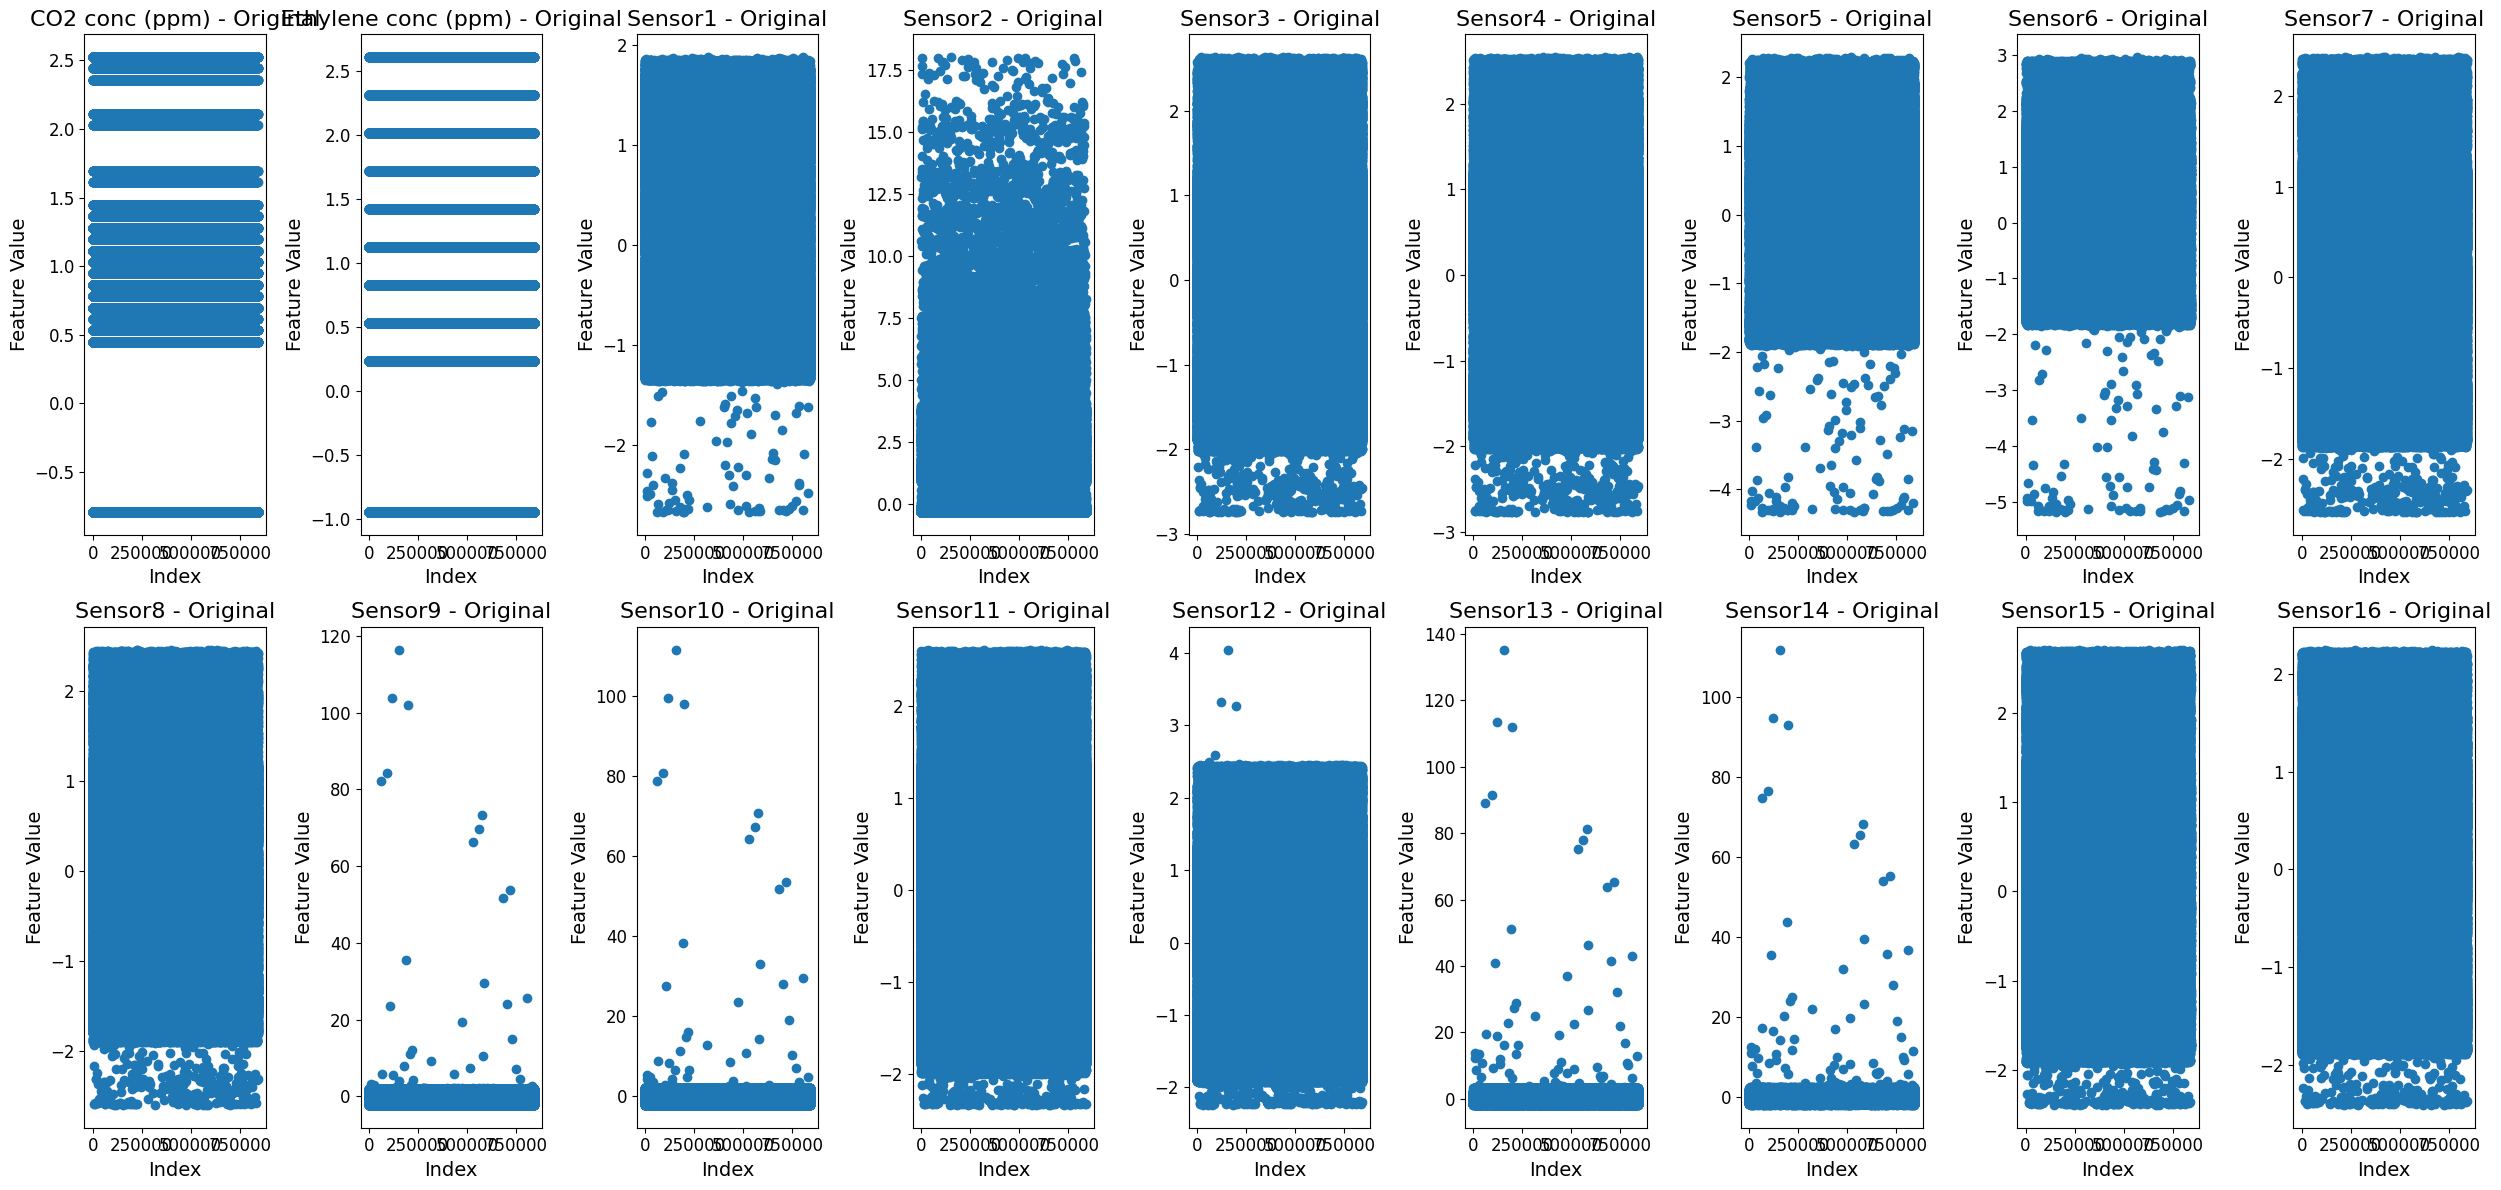

In [10]:

plt.figure(figsize=(25, 12))
for i, column in enumerate(features.columns):
    plt.subplot(2, len(features.columns) // 2, i + 1)
    plt.scatter(np.arange(len(X_test)), X_test[:, i], label=f'{column}')
    plt.title(f'{column} - Original', fontsize=16)  # Adjust font size for title
    plt.xlabel('Index', fontsize=14)  # Adjust font size for x-axis label
    plt.ylabel('Feature Value', fontsize=14)  # Adjust font size for y-axis label
    plt.xticks(fontsize=12)  # Adjust font size for x-axis ticks
    plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks

plt.tight_layout()

# Save the figure before showing or closing
plt.savefig('Actual_data.jpg')

# Show the plot
plt.show()

# Close the plot
plt.close()




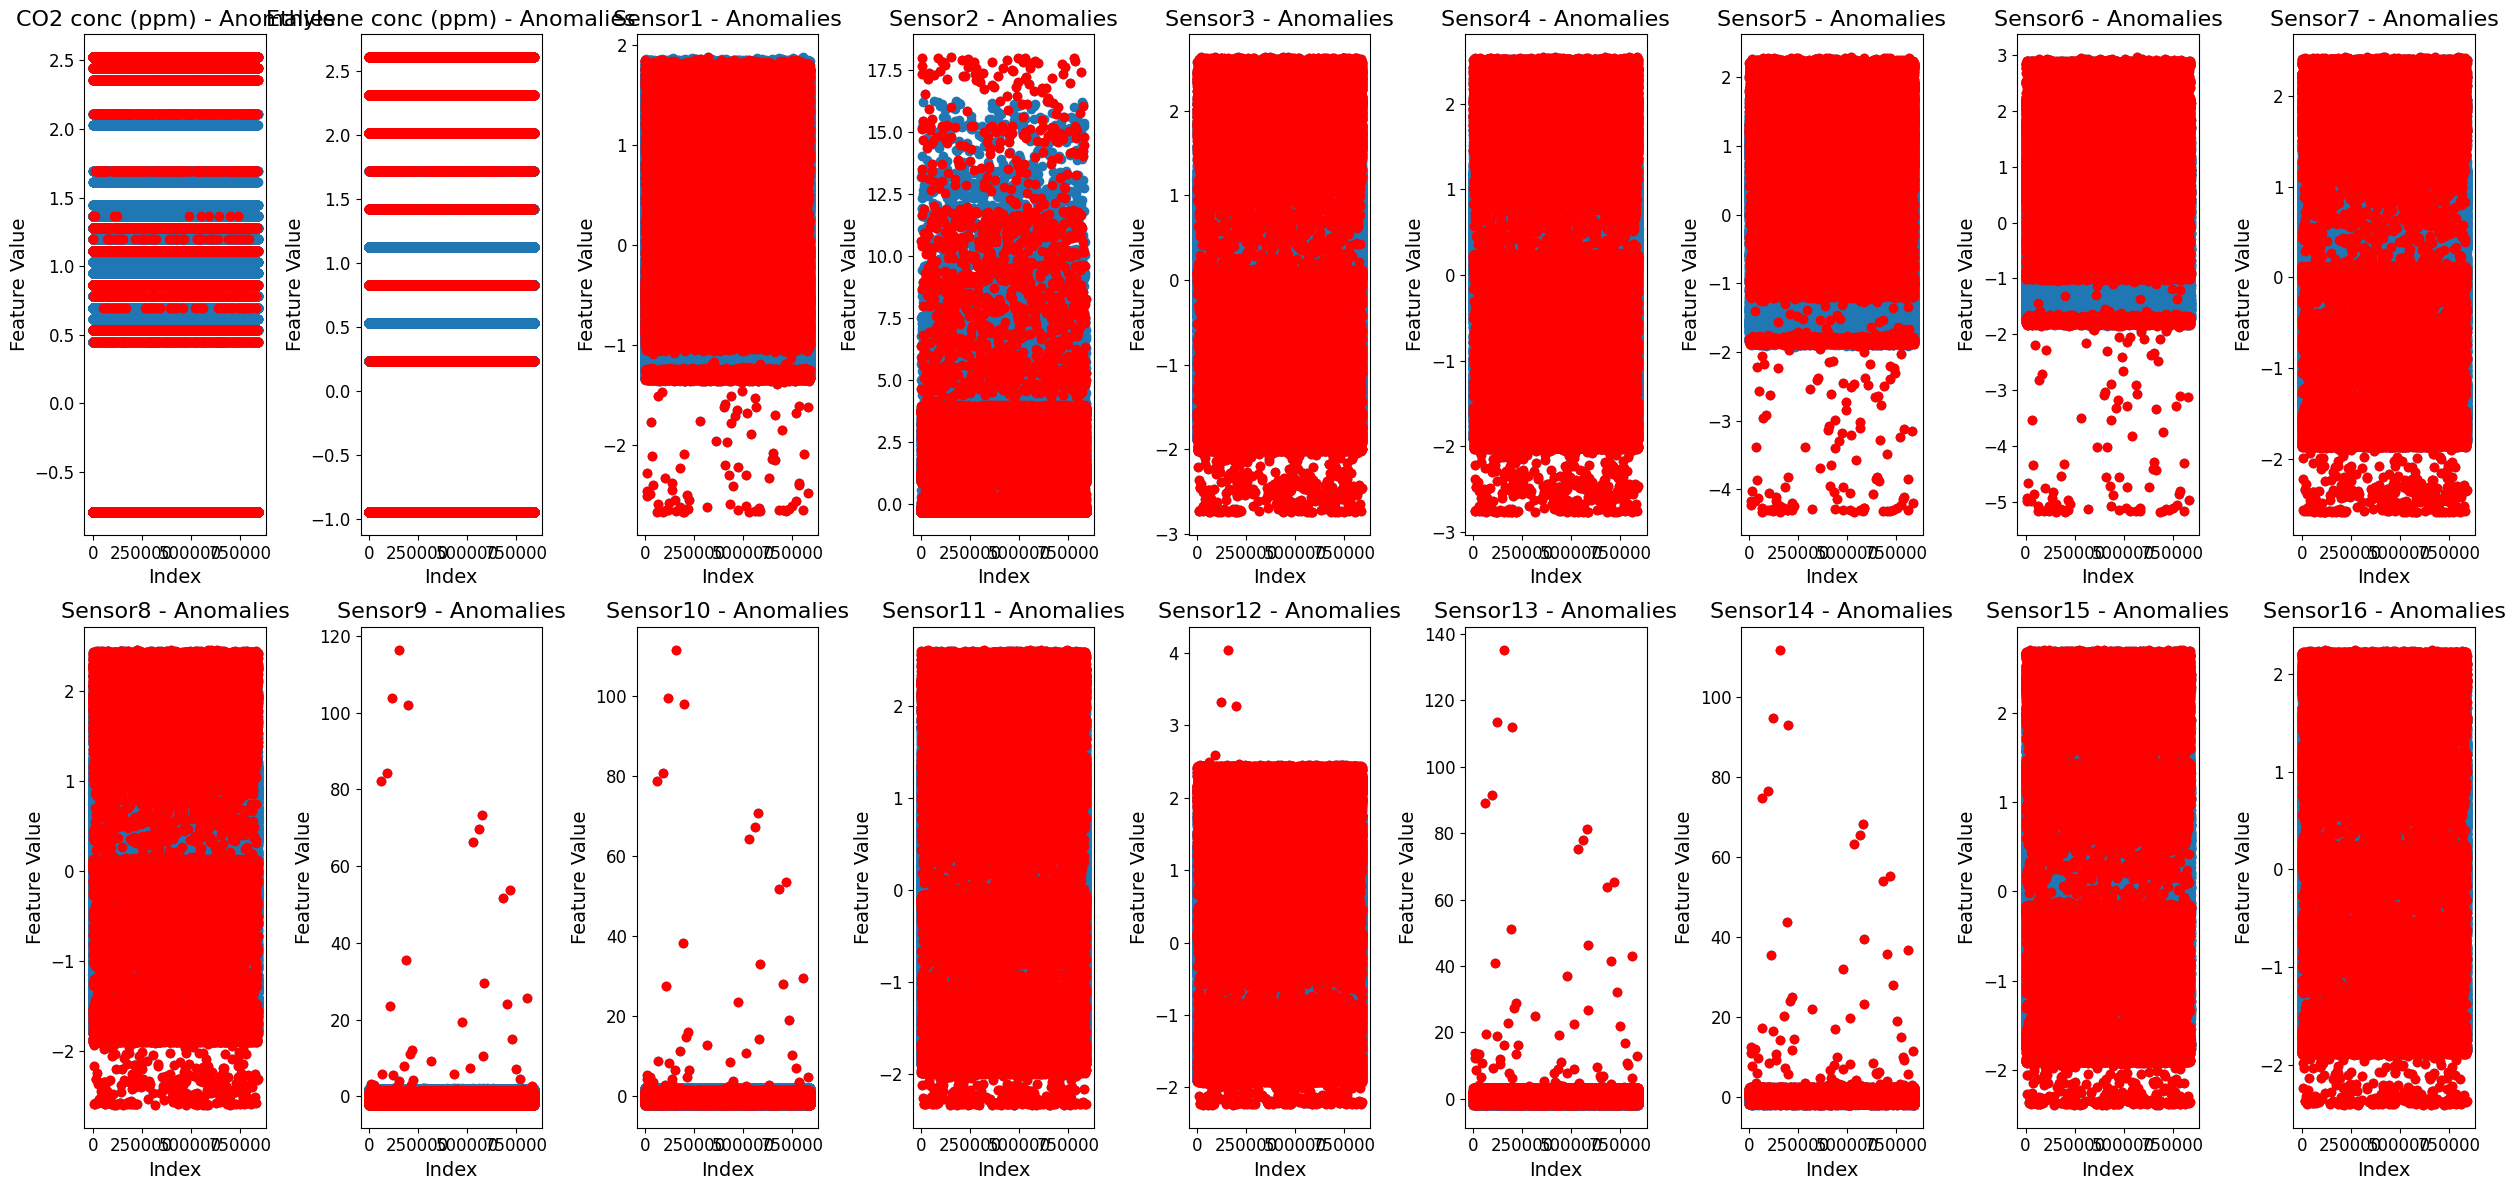

In [11]:

plt.figure(figsize=(25, 12))

for i, column in enumerate(features.columns):
    plt.subplot(2, len(features.columns) // 2, i + 1)
    plt.scatter(np.arange(len(X_test)), X_test[:, i], label=f'{column}')
    plt.scatter(np.arange(len(X_test))[predictions == -1], X_test[:, i][predictions == -1], color='red', label='Anomaly')
    plt.title(f'{column} - Anomalies', fontsize=16)  # Adjust font size for title
    plt.xlabel('Index', fontsize=14)  # Adjust font size for x-axis label
    plt.ylabel('Feature Value', fontsize=14)  # Adjust font size for y-axis label
    plt.xticks(fontsize=12)  # Adjust font size for x-axis ticks
    plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks

plt.tight_layout()

# Save the figure before showing or closing
plt.savefig('predicted_anomalies.jpg')

# Show the plot
plt.show()

# Close the plot
plt.close()


In [8]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'contamination': [0.01, 0.05, 0.1]
}

# Create a scorer that doesn't require y_true (ground truth labels)
scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Combine the Isolation Forest model instantiation with the grid search
grid_search = GridSearchCV(
    estimator=IsolationForest(),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1  # Use all available CPU cores for parallelization
)
# Fit the model to the training data
grid_search.fit(X_train)
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'contamination': 0.01, 'n_estimators': 50}


In [9]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

In [10]:
best_model

IsolationForest(contamination=0.01, n_estimators=50)

In [11]:
# Calculate average outliers in the training data
average_outliers_train = np.mean(grid_search.score_samples(X_train))

# Calculate average outliers in the test data
average_outliers_test = np.mean(grid_search.score_samples(X_test))

# Print rounded values
print('Average Outliers in the Training data:', round(average_outliers_train, 2))
print('Average Outliers in the Test data:', round(average_outliers_test, 2))

Average Outliers in the Training data: -0.47
Average Outliers in the Test data: -0.47


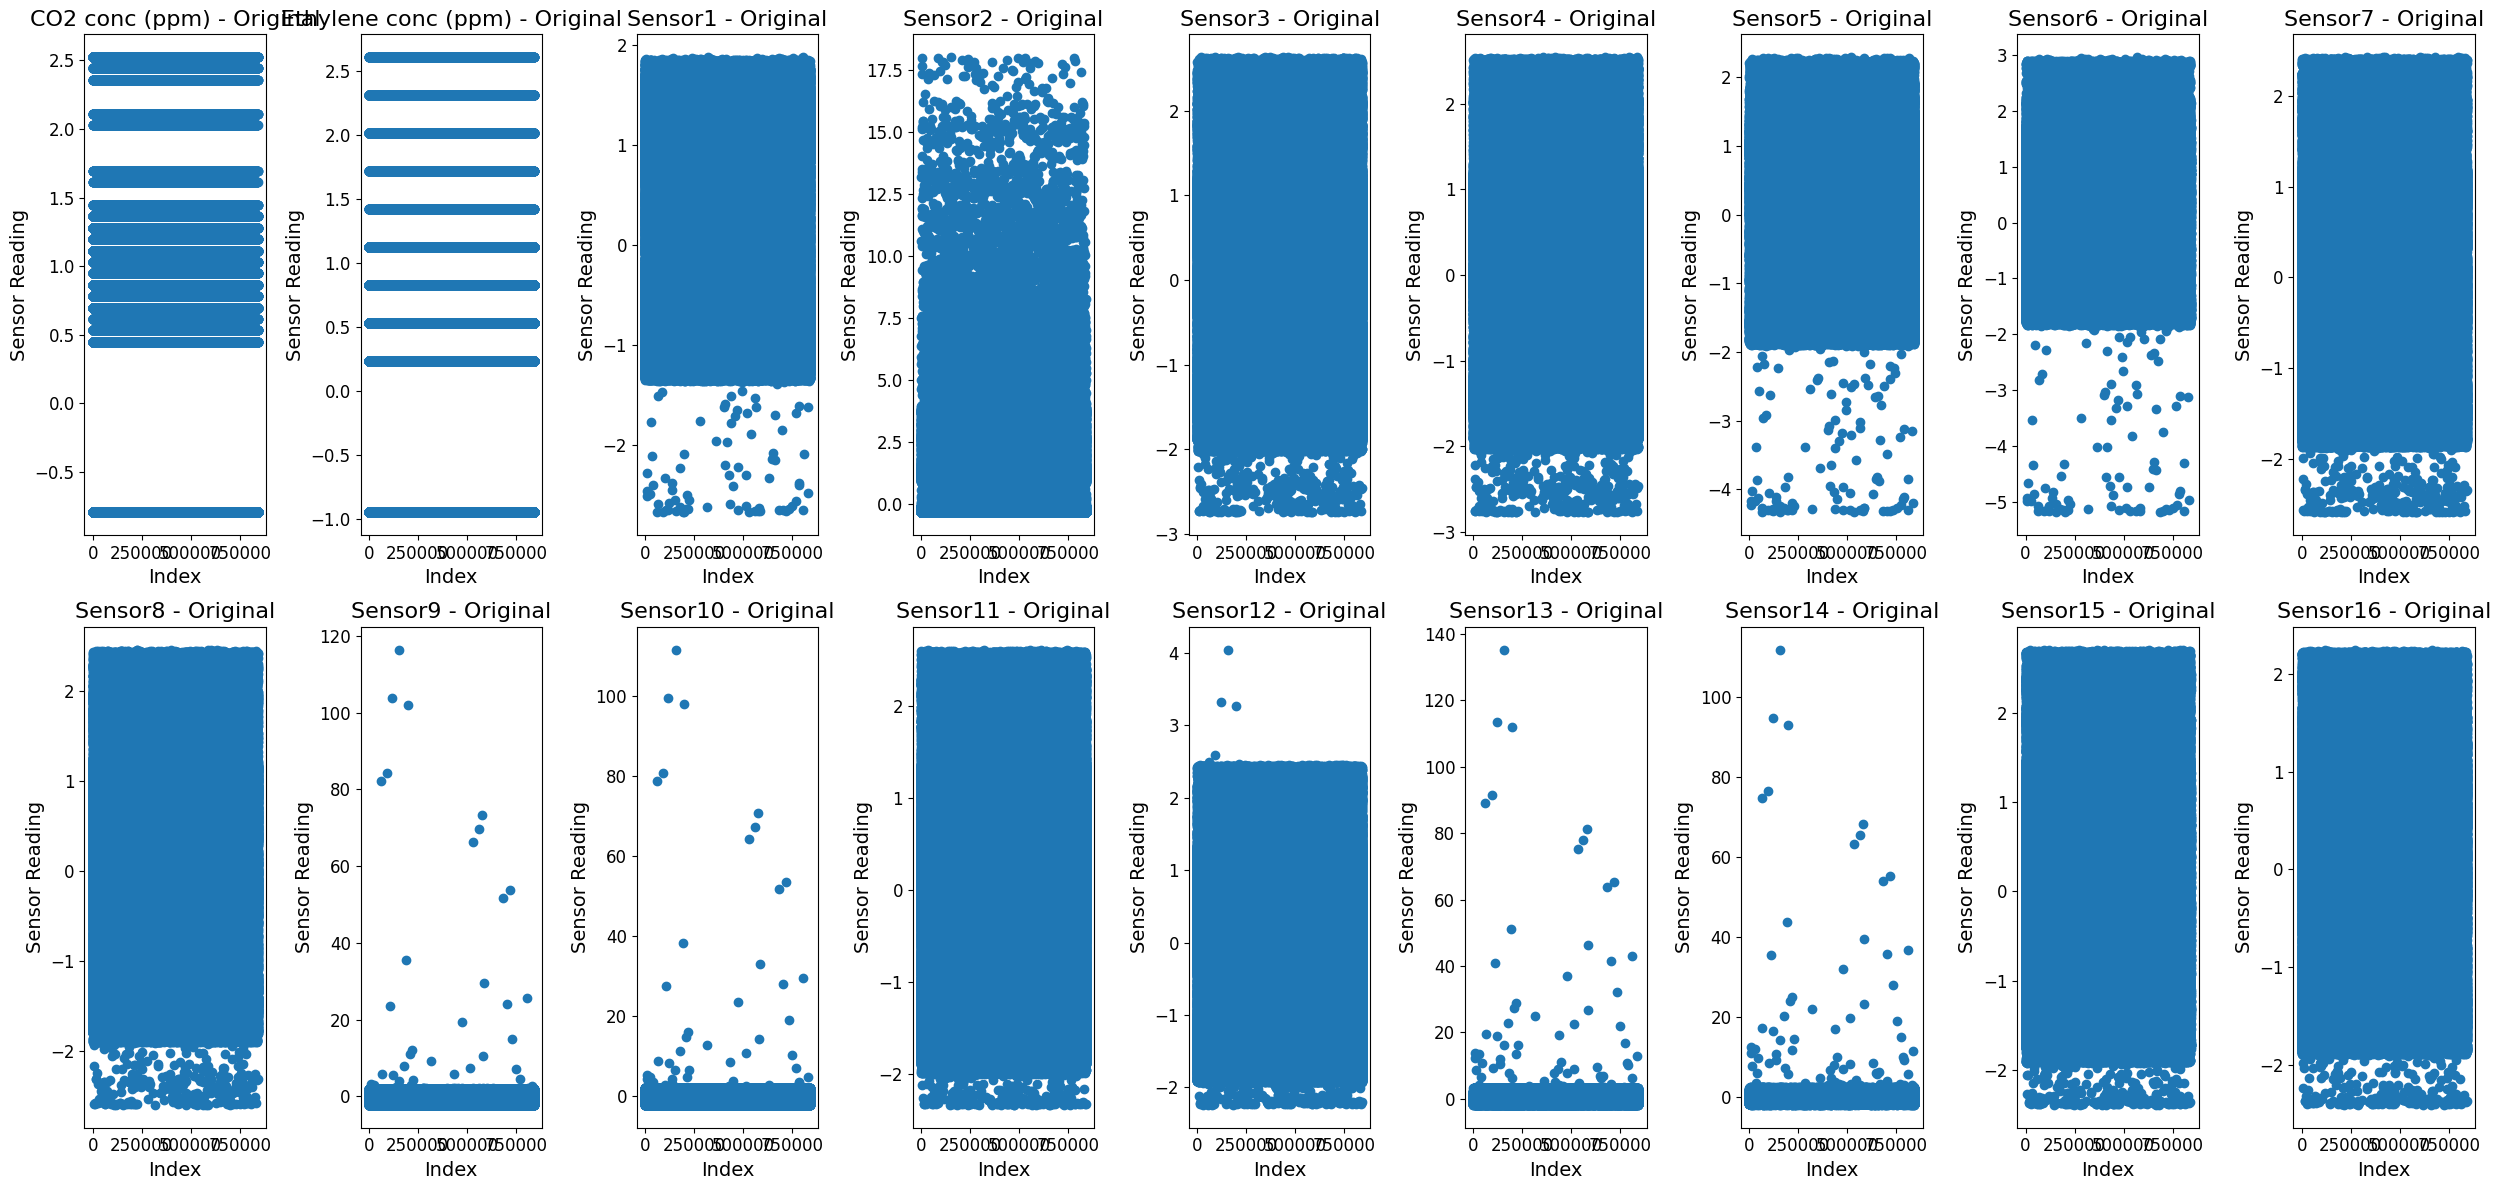

In [12]:
plt.figure(figsize=(25, 12))
for i, column in enumerate(features.columns):
    plt.subplot(2, len(features.columns) // 2, i + 1)
    plt.scatter(np.arange(len(X_test)), X_test[:, i], label=f'{column}')
    plt.title(f'{column} - Original', fontsize=16)  # Adjust font size for title
    plt.xlabel('Index', fontsize=14)  # Adjust font size for x-axis label
    plt.ylabel('Sensor Reading', fontsize=14)  # Adjust font size for y-axis label
    plt.xticks(fontsize=12)  # Adjust font size for x-axis ticks
    plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks

plt.tight_layout()
plt.savefig('Actual_data.jpg')
plt.show()
plt.close()


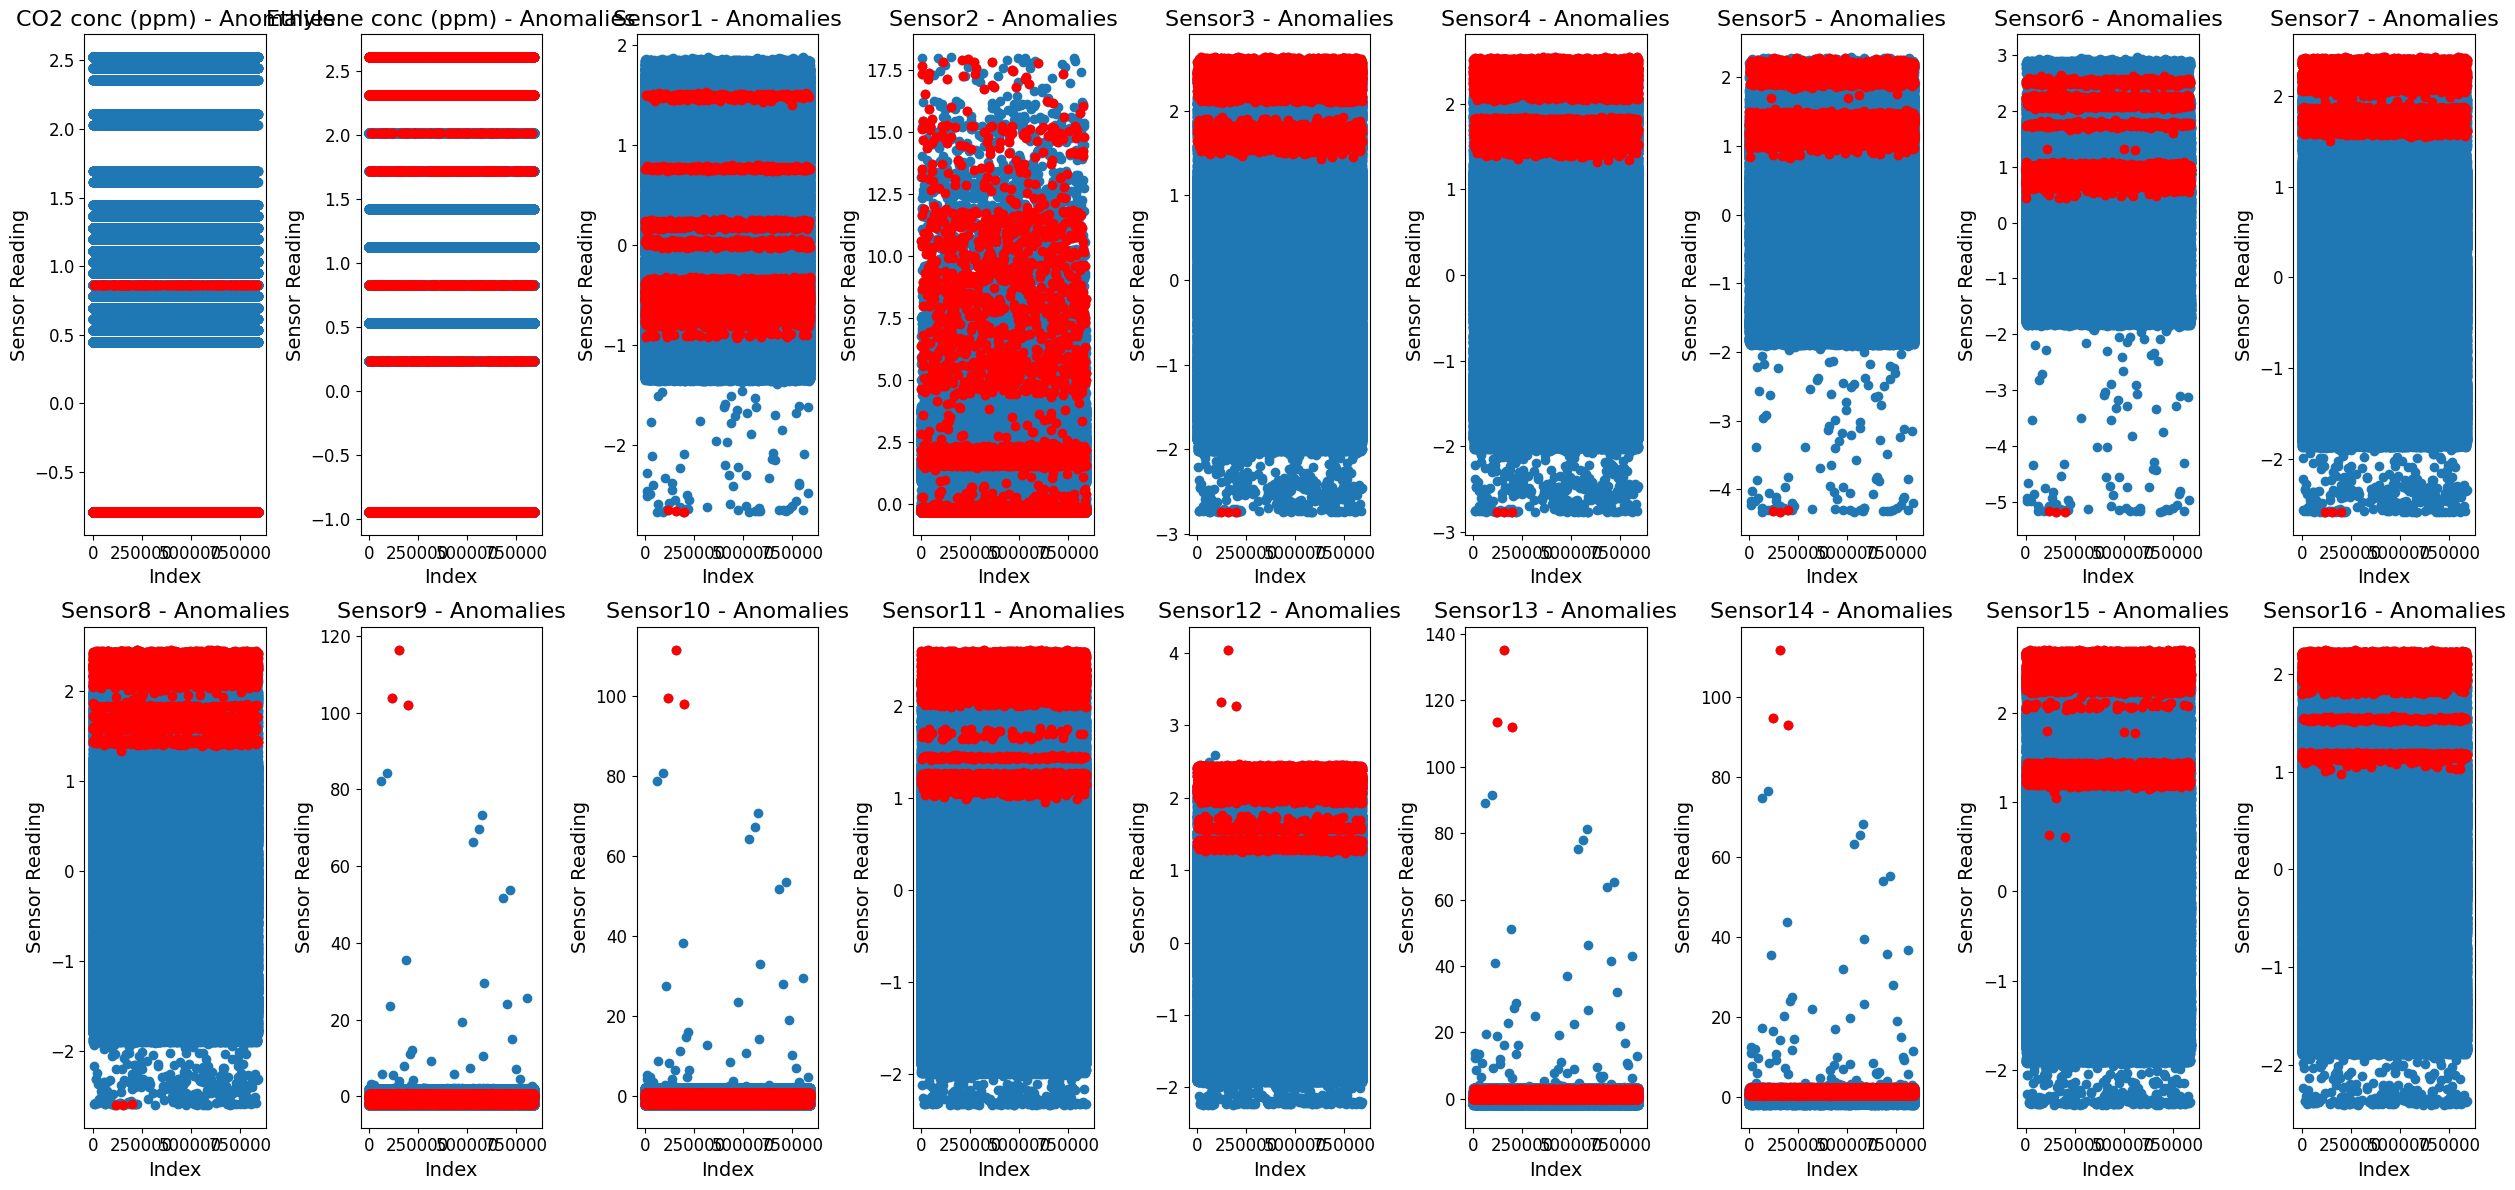

In [13]:
plt.figure(figsize=(25, 12))

for i, column in enumerate(features.columns):
    plt.subplot(2, len(features.columns) // 2, i + 1)
    plt.scatter(np.arange(len(X_test)), X_test[:, i], label=f'{column}')
    plt.scatter(np.arange(len(X_test))[predictions == -1], X_test[:, i][predictions == -1], color='red', label='Anomaly')
    plt.title(f'{column} - Anomalies', fontsize=16)  # Adjust font size for title
    plt.xlabel('Index', fontsize=14)  # Adjust font size for x-axis label
    plt.ylabel('Sensor Reading', fontsize=14)  # Adjust font size for y-axis label
    plt.xticks(fontsize=12)  # Adjust font size for x-axis ticks
    plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks

plt.tight_layout()
# Save the figure before showing or closing
plt.savefig('Hypertuned_predicted_anomalies.jpg')
# Show the plot
plt.show()
# Close the plot
plt.close()


Results

In [1]:

from prettytable import PrettyTable


results = PrettyTable(["Model ", "Test Anamoly Score"])

# Add rows
results.add_row(["Isolation Forest", "47%"])
results.add_row(["Isolation Forest (Grid Search)", "46%"])

print(results)

+--------------------------------+--------------------+
|             Model              | Test Anamoly Score |
+--------------------------------+--------------------+
|        Isolation Forest        |        47%         |
| Isolation Forest (Grid Search) |        46%         |
+--------------------------------+--------------------+


After tunining the model we got 46% outlier on unseen data.